# Проект «Линейные модели в машинном обучении»

### Описание задачи

Мы работаем в IT-компании, которая выполняет на заказ проекты по машинному обучению.
К нам обратился фермер (далее — заказчик), владелец молочного хозяйства.
Заказчик хочет купить буренок, чтобы расширить поголовье стада коров.

Заказчик при этом имеет возможность тщательно отбирать коров, руководствуясь двумя критериями: удой и вкус молока.

#### Постановка задачи

Требуется разработать модель машинного обучения, позволяющая заказчику управлять рисками на основе данных, предоставленных продавцом буренок.

Необходимо создать 2 прогнозные модели:
* Первая модель прогнозирует возможный удой.
* Вторая модель рассчитывает вероятность получить вкусное молоко от коровы.

### Описание данных

Мы имеем 3 (три) датасета:
* ferma_main.csv — содержит данные о стаде фермера на текущий момент


  Данные можно разбить на 4 (четыре) группы:
  * Характеристики коровы
  * Характеристика корма
  * Характеристики пастбища
  * Характеристики молока

* ferma_dad.csv — хранит имя папы коровы в стаде фермера

* cow_buy.csv — данные о коровах продавца, которые фермер хочет изучить перед покупкой
  Такие же данные, как и в ferma_main.csv, но со следующими важными отличиями:
  * Содержание белков и жиров в молоке указано на момент продажи
  * Характеристики корма отсутствуют. Технологи заказчика планируют увеличить значения каждого из параметров на $5\%$
  * Отсутствуют целевые признаки, которые и следует предсказать.

## Загрузка библиотек

In [2]:
!pip install -U scikit-learn

DEPRECATION: Loading egg at /usr/lib64/python3.11/site-packages/TBB-2021.12.0-py3.11-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try
    zypper install python311-xyz, where xyz is the package
    you are trying to install.
    
    If you wish to install a non-rpm packaged Python package,
    create a virtual environment using python3.11 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-rpm packaged Python application,
    it may be easiest to use `pipx install xyz`, which will manage a
    virtual environment for you. Install pipx via `zypper install python311-pipx` .

note: If you believe this is a mistake, please contact your Py

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

## Загрузка данных

In [4]:
filename_main = 'ferma_main.csv'
filename_dad = 'ferma_dad.csv'
filename_cow = 'cow_buy.csv'

In [5]:
try:
    data_main = pd.read_csv('/datasets/' + filename_main)
except:
    data_main = pd.read_csv(filename_main)

In [6]:
try:
    data_dad = pd.read_csv('/datasets/' + filename_dad)
except:
    data_dad = pd.read_csv(filename_dad)

In [7]:
try:
    data_cow = pd.read_csv('/datasets/' + filename_cow)
except:
    data_cow = pd.read_csv(filename_cow)

#### Осмотр данных

Посмотрим на датасет

In [8]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column                                                                                 Non-Null Count  Dtype 
---  ------                                                                                 --------------  ----- 
 0   id;Удой                                                                                634 non-null    object
 1    кг;ЭКЕ (Энергетическая кормовая единица);Сырой протеин                                634 non-null    object
 2    г;СПО (Сахаро-протеиновое соотношение);Порода;Тип пастбища;порода папы_быка;Жирность  634 non-null    object
 3   %;Белок                                                                                634 non-null    object
 4   %;Вкус молока;Возраст                                                                  616 non-null    object
dtypes: object(5)
memory usage: 24.9+ KB


Видим, что из названия столбцов выходит, что разделителем должен быть знак ';'.
Проверим это, взглянув на первые 5 строк данных.

In [9]:
data_main.head(5)

,id;Удой,кг;ЭКЕ (Энергетическая кормовая единица);Сырой протеин,г;СПО (Сахаро-протеиновое соотношение);Порода;Тип пастбища;порода папы_быка;Жирность,%;Белок,%;Вкус молока;Возраст
0,1;5863;14,2;1743;0,89;Вис Бик Айдиал;Равнинное;Айдиал;3,58;3,076;вкусно;более_2_лет
1,2;5529;12,8;2138;0,89;Вис Бик Айдиал;Равнинные;Соверин;3,54;3,079;вкусно;менее_2_лет
2,3;5810;14;1854;0,885;РефлешнСоверинг;Холмистое;Соверин;3,59;3,074;не вкусно;более_2_лет,NaN
3,4;5895;12,4;2012;0,885;РефлешнСоверинг;Холмистое;Айдиал;3,4;3,075;не вкусно;более_2_лет
4,5;5302;12,8;1675;0,885;Вис Бик Айдиал;Равнинные;Соверин;3,73;3,073;вкусно;менее_2_лет


Видим, что данные загрузились не вполне корректно.
Разделителем данных (delimiter) служит знак ';', а десятичным разделителем (decimal) — знак ','.

Перезагрузим данные с учетом этих особенностей.

In [10]:
try:
    data_main = pd.read_csv('/datasets/' + filename_main, delimiter=';', decimal=',')
except:
    data_main = pd.read_csv(filename_main, delimiter=';', decimal=',')

In [11]:
try:
    data_dad = pd.read_csv('/datasets/' + filename_dad, delimiter=';', decimal=',')
except:
    data_dad = pd.read_csv(filename_dad, delimiter=';', decimal=',')

In [12]:
try:
    data_cow = pd.read_csv('/datasets/' + filename_cow, delimiter=';', decimal=',')
except:
    data_cow = pd.read_csv(filename_cow, delimiter=';', decimal=',')

In [13]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Теперь все корректно.
Аналогично проверим остальные датасеты.

In [14]:
data_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Все нормально, а десятичных данных тут нет.

In [15]:
data_cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Все загрузилось корректно.
Для удобства и единообразия стиля переименуем столбцы.

#### Переименование столбцов

Переименуем столбцы на единнообразные, придерживаясь схемы:
* Для типа добавляем _type
* Для текущего уровня добавляем _curr
* Столбцы булевого типа именуются по шаблону is_<смысловое_имя>

In [16]:
data_main = data_main.rename(columns={
    'Удой, кг': 'yield',
    'ЭКЕ (Энергетическая кормовая единица)': 'feed_energy',
    'Сырой протеин, г': 'raw_protein',
    'СПО (Сахаро-протеиновое соотношение)': 'carb_protein_ratio',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'breed_dad',
    'Жирность,%': 'fat_content',
    'Белок,%': 'protein',
    'Вкус молока': 'is_delicious',
    'Возраст': 'is_older2',
})

In [17]:
data_dad = data_dad.rename(columns={
    'Имя Папы': 'name_dad'
})

In [18]:
data_cow = data_cow.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'breed_dad',
    'Имя_папы': 'name_dad',
    'Текущая_жирность,%': 'fat_content_curr',
    'Текущий_уровень_белок,%': 'protein_curr',
    'Возраст': 'is_older2'
})

Переименование готово.

Создадим теперь словарь из переименованных столбцов для корректного автоматического вывода графиков (пригодится позднее)

In [19]:
data_main_cols_dict = dict({
    'yield': 'Удой',
    'feed_energy': 'ЭКЕ',
    'feed_energy_squared': 'ЭКЕ в квадрате',
    'raw_protein': 'Сырой протеин',
    'carb_protein_ratio': 'СПО',
    'breed': 'Порода',
    'pasture_type': 'Тип пастбища',
    'breed_dad': 'Порода папы',
    'fat_content': 'Жирность',
    'protein': 'Белок',
    'is_delicious': 'Вкус молока',
    'is_older2': 'Возраст',
    'name_dad': 'Имя папы'
})

## Предобработка данных

Взглянем еще раз на наши датасеты.

In [20]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  634 non-null    int64  
 1   yield               634 non-null    int64  
 2   feed_energy         634 non-null    float64
 3   raw_protein         634 non-null    int64  
 4   carb_protein_ratio  634 non-null    float64
 5   breed               634 non-null    object 
 6   pasture_type        634 non-null    object 
 7   breed_dad           634 non-null    object 
 8   fat_content         634 non-null    float64
 9   protein             634 non-null    float64
 10  is_delicious        634 non-null    object 
 11  is_older2           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [21]:
data_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   name_dad  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [22]:
data_cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   breed             20 non-null     object 
 1   pasture_type      20 non-null     object 
 2   breed_dad         20 non-null     object 
 3   name_dad          20 non-null     object 
 4   fat_content_curr  20 non-null     float64
 5   protein_curr      20 non-null     float64
 6   is_older2         20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


#### Уточнение типов данных

Приведем тип данных в столбцах is_delicios (вкус молока) и is_older2 (возраст).

Сначала проверим уникальность хранящихся в них значений

In [23]:
data_main['is_delicious'].unique()

array(['вкусно', 'не вкусно'], dtype=object)

In [24]:
data_main['is_older2'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

In [25]:
data_cow['is_older2'].unique()

array(['более_2_лет', 'менее_2_лет'], dtype=object)

и изменим тип данных на булев по правилу:
* Для столбца is_delicious (вкус молока) значение «вкусно» соответствует True, «не вкусно» — False.
* Для столбца is_older2 (возраст) значение «более_2_лет» соответствует True, «менее_2_лет» — False.

In [26]:
data_main['is_delicious'] = data_main['is_delicious'].map({'вкусно': True, 'не вкусно': False})

In [27]:
data_main['is_older2'] = data_main['is_older2'].map({'более_2_лет': True, 'менее_2_лет': False})

In [28]:
data_cow['is_older2'] = data_cow['is_older2'].map({'более_2_лет': True, 'менее_2_лет': False})

### Очистка данных

#### Явные дубликаты

Проверим наличие явных дубликатов в каждом из датасетов.

In [29]:
data_main.duplicated().sum()

np.int64(5)

In [30]:
data_dad.duplicated().sum()

np.int64(0)

In [31]:
data_cow.duplicated().sum()

np.int64(4)

Изучим дубликаты.

In [32]:
data_main[data_main.duplicated()]

,id,yield,feed_energy,raw_protein,carb_protein_ratio,breed,pasture_type,breed_dad,fat_content,protein,is_delicious,is_older2
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,False,True
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,False,True
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,False,True
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,False,True
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,False,True


Мы видим одинаковые коровы, являющиеся копией коровы с id равным 627.
Вот «оригинальная» корова.

In [33]:
data_main[data_main['id'] == 627].iloc[:1]

,id,yield,feed_energy,raw_protein,carb_protein_ratio,breed,pasture_type,breed_dad,fat_content,protein,is_delicious,is_older2
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,False,True


Что касательно дубликатов датасета data_cow, то ввиду отсутствия заведомо уникальных признаков (например, ID), мы не можем делать вывод о том, что это именно дубликаты, поэтому оставляем как есть.

Таким образом, удалим дубликаты только из датасета data_main.

In [34]:
data_main.drop_duplicates(inplace=True)

#### Неявные дубликаты

Осуществим проверку неявных дубликатов.

In [35]:
data_main.head()

,id,yield,feed_energy,raw_protein,carb_protein_ratio,breed,pasture_type,breed_dad,fat_content,protein,is_delicious,is_older2
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,True,True
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,True,False
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,False,True
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,False,True
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,True,False


Видим разное наименование одинаковых пород: «Вис Бик Айдиал» и «Айдиал», а также «РефлекшнСоверин» и «Соверин».
Устраним это, проверив заодно уникальные значения пород (возможно, их больше двух).

In [36]:
data_main['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [37]:
data_main.loc[data_main['breed'] == 'Вис Бик Айдиал', 'breed'] = 'Айдиал'

In [38]:
data_main.loc[data_main['breed'] == 'РефлешнСоверинг', 'breed'] = 'Соверин'

Видим аналогичную картину для пастбищ («Равнинное» и «Равнинные»).
Устраним это.

In [39]:
data_main['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [40]:
data_main.loc[data_main['pasture_type'] == 'Равнинные', 'pasture_type'] = 'Равнинное'

Аналогичным образом проверим значения пород отца и устраним дубликаты, если они есть.

In [41]:
data_main['breed_dad'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [42]:
data_main.loc[data_main['breed_dad'] == 'Айдиалл', 'breed_dad'] = 'Айдиал'

Теперь аналогичным образом проверим датасет data_cow.

In [43]:
data_cow.head()

,breed,pasture_type,breed_dad,name_dad,fat_content_curr,protein_curr,is_older2
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,True
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,False
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,True
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,True
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,True


Видим аналогичную картину. Исправляем.

In [44]:
data_cow.loc[data_cow['breed'] == 'Вис Бик Айдиал', 'breed'] = 'Айдиал'

In [45]:
data_cow.loc[data_cow['breed'] == 'РефлешнСоверинг', 'breed'] = 'Соверин'

In [46]:
data_cow['breed_dad'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

Также изменим в датасете data_cow значения признака pasture_type («Тип пастбища») на аналогичные значения из датасета data_main
(то есть заменим строчные буквы на прописные)

In [47]:
data_cow.loc[data_cow['pasture_type'] == 'холмистое', 'pasture_type'] = 'Холмистое'

In [48]:
data_cow.loc[data_cow['pasture_type'] == 'равнинное', 'pasture_type'] = 'Равнинное'

Предобработка данных завершена.
Сохраним копии датасетов для последующей загрузки в «неизмененном» виде по необходимости.

In [49]:
data_main_arch = data_main
data_dad_arch = data_dad
data_cow_arch = data_cow

## Исследовательский анализ данных

Посмотрим на описательную статистику количественных признаков в датасете data_main.

In [50]:
data_main.loc[:, data_main.columns != 'id'].describe()

,yield,feed_energy,raw_protein,carb_protein_ratio,fat_content,protein
count,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Мы сразу видим аномально высокое максимальное значение признака yield («Удой»).
У признаков feed_energy («ЭКЕ»), raw_protein («Сырой протеин»), carb_protein_ratio («СПО») выбросов нет, т.к. их максимальные и минимальные значения лежат в пределах "усов".
У признаков fat_content и protein выбросы есть.

Посмотрим на диаграмму размаха признаков yield, fat_content и protein.

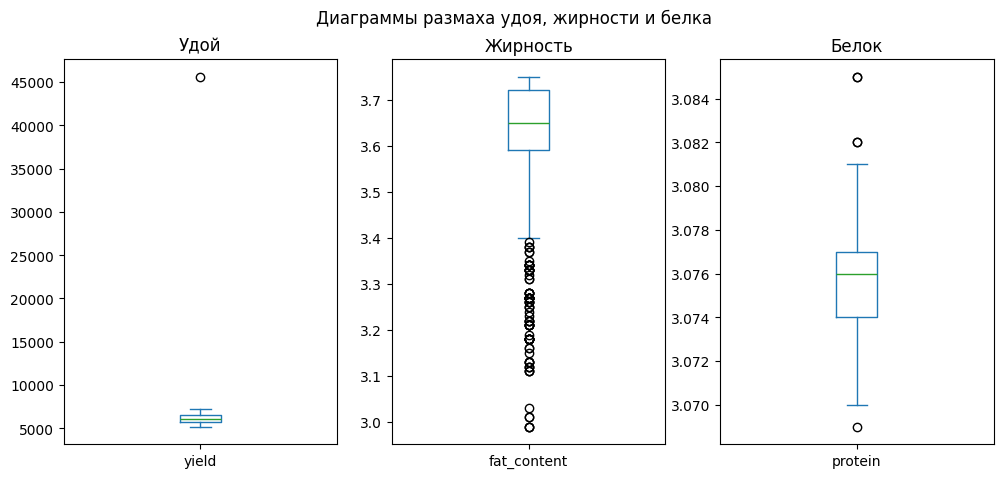

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Диаграммы размаха удоя, жирности и белка')
data_main['yield'].plot(ax=ax[0],kind='box', title='Удой', ylabel='');
data_main['fat_content'].plot(ax=ax[1],kind='box', title='Жирность', ylabel='');
data_main['protein'].plot(ax=ax[2],kind='box', title='Белок', ylabel='');

Видим у признака yield (Удой) выброс и он имеет явно аномальный характер, удалим его.

У остальных выбросы имеют правдоподобные значения оставляем их.

In [52]:
data_main = data_main[data_main['yield'] < 10000]

Посмотрим на распределения признаков.

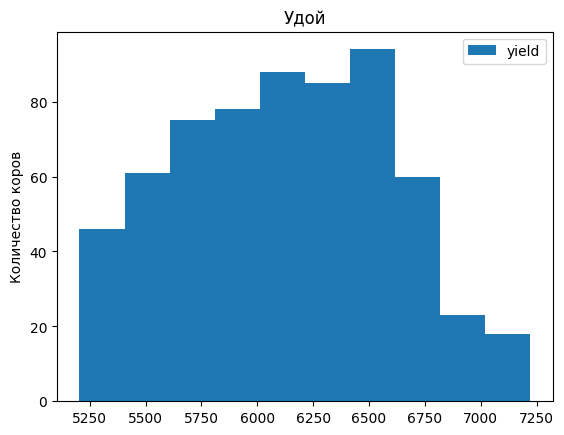

In [53]:
data_main.plot(kind='hist', y='yield', ylabel='Количество коров', title='Удой');

Мы видим, что распределение несимметрично, видим резкое падение поголовья коров в стаде после значения признака в 6750 кг ввиду, судя по всему, редкости таких коров среди популяции -- соответственно, и в конкретном стаде тоже, несмотря на то, что в стадо их отбирали в том числе и по потенциально максимальному удою.

Рассмотрим, сколько коров в стаде соответствует целевому значению 6000 (или более) признака yield («Удой»).

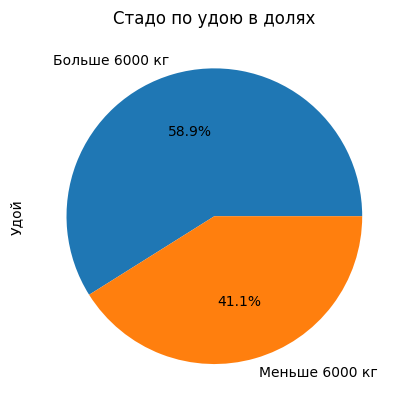

In [54]:
data_main['yield'] \
    .apply(lambda x: 'Больше 6000 кг' if x >= 6000 else 'Меньше 6000 кг') \
    .value_counts().plot(kind='pie', ylabel='Удой', title='Стадо по удою в долях', autopct='%1.1f%%');

Мы видим, что доля коров в стаде с годовым удоем выше 6000 кг почти на 10 процентных пунктов выше доли коров с удоем меньше 6000 кг.

Посмотрим на распределение признака feed_energy («ЭКЕ»).

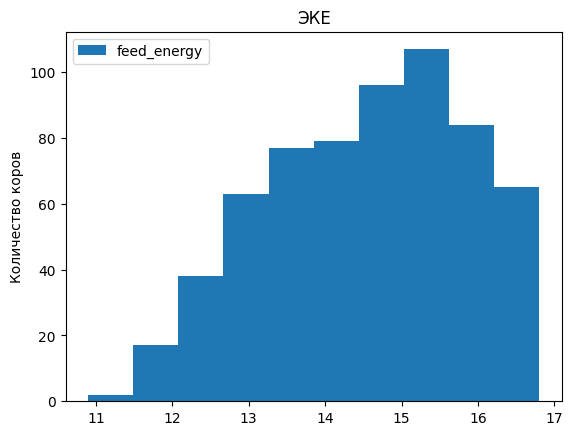

In [55]:
data_main.plot(kind='hist', y='feed_energy', ylabel='Количество коров', title='ЭКЕ');

Мы видим, что большинство коров питается кормом с показателем 13 и выше.

Теперь посмотрим на распредление признака raw_protein (Сырой протеин)

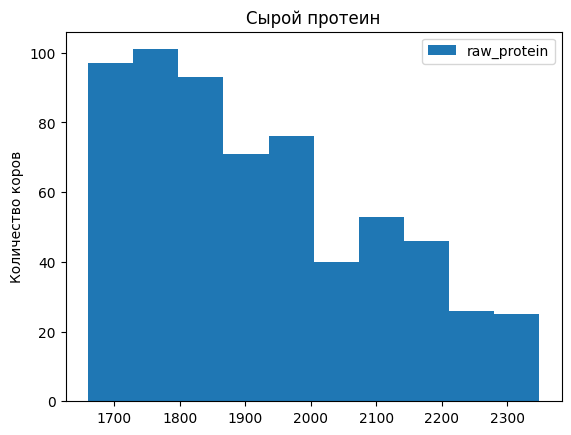

In [56]:
data_main.plot(kind='hist', y='raw_protein', ylabel='Количество коров', title='Сырой протеин');

Видим, что количество коров, в кормах которых присутствует сырой протеин убывает с ростом содержания сырого протеина в корме.

Посмотрим на распределение признака carb_protein_ratio (Сахарно-протеиновое отношение)

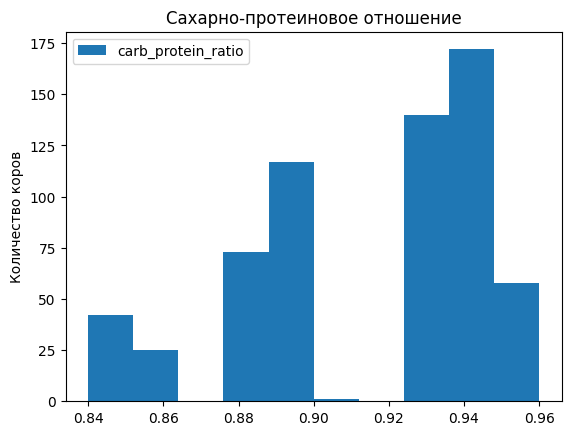

In [57]:
data_main.plot(kind='hist', y='carb_protein_ratio', ylabel='Количество коров', title='Сахарно-протеиновое отношение');

Мы видим разрывы в данных: например, данных о коровах, питающихся кормом с СПО 0.87 или 0.92, в выборке нет вообще.

Возможно, это связано со стандартизацией типов кормов (допустим, фермер решил кормить свое стадо тремя разными кормами).

Проверка на корреляцию кормления коров разных пород.

Рассмотрим распределение признака fat_content (Жирность).

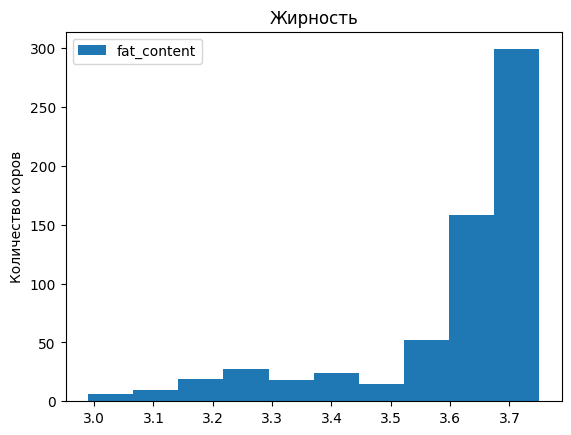

In [58]:
data_main.plot(kind='hist', y='fat_content', ylabel='Количество коров', title='Жирность');

Видим, что в стаде преобладают коровы, дающие высокую (выше 3.6) жирность,— это, судя по всему, было одним из важных качеств аыходного
продукта и фермер делал на это упор.
Возможно, впрочем, это означает, что здоровые коровы в принципе дают молоко такой жирности, а все остальное — симптом проблем с
отдельными особями коровы.

Рассмотрим распределение признака protein (белок).

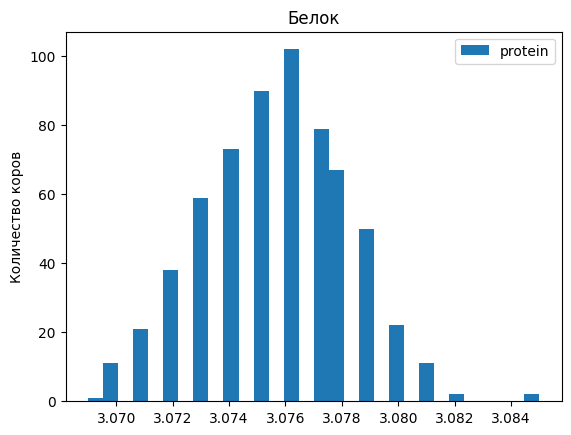

In [59]:
data_main.plot(kind='hist', y='protein', ylabel='Количество коров', title='Белок', bins=30);

Видим, что распределение похоже на нормальное со средним в 3.076 (есть выброс справа).
Это может говорить о том, что этот признак не влиял на отбор буренок в стадо, а сам этот признак слабо не связан с остальными, влиявшими на такой отбор.

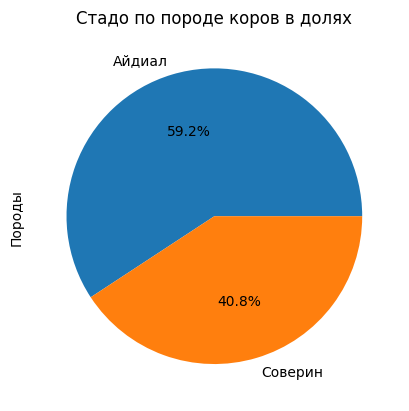

In [60]:
data_main['breed'] \
    .value_counts() \
    .plot(kind='pie', ylabel='Породы', title='Стадо по породе коров в долях', autopct='%1.1f%%');

Мы видим, что в стаде коров породы «Айдиал» в полтора раза больше коров породы «Соверин».

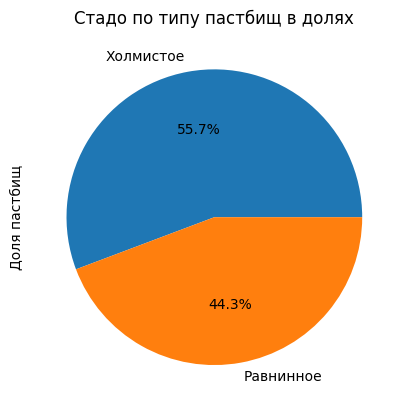

In [61]:
data_main['pasture_type'] \
    .value_counts() \
    .plot(kind='pie', ylabel='Доля пастбищ', title='Стадо по типу пастбищ в долях', autopct='%1.1f%%');

Видим почти равное распределение коров в стаде по типам пастбищ.

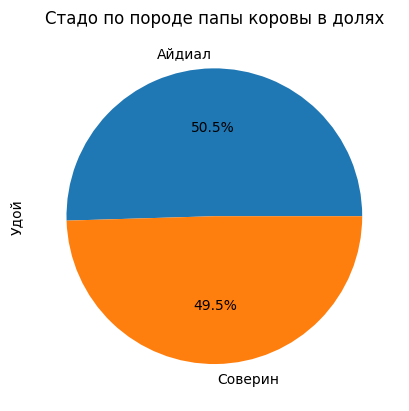

In [62]:
data_main['breed_dad'] \
    .value_counts() \
    .plot(kind='pie', ylabel='Удой', title='Стадо по породе папы коровы в долях', autopct='%1.1f%%');

Мы видим, что стадо поделено, в целом, поровну по признаку breed_dad («Порода папы коровы»).

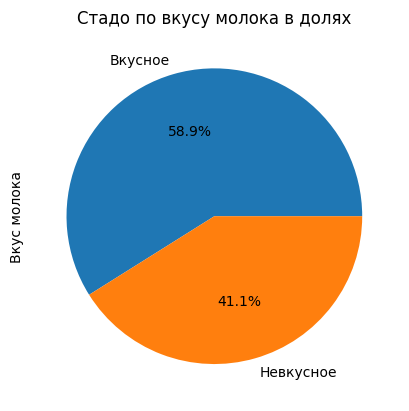

In [63]:
data_main['is_delicious'] \
    .apply(lambda x: 'Вкусное' if x >= True else 'Невкусное') \
    .value_counts().plot(kind='pie', ylabel='Вкус молока', title='Стадо по вкусу молока в долях', autopct='%1.1f%%');

Мы видим, что доля невкусного молока от коров в стаде высока — $40\%$, чем и обусловлен интерес фермера повысить долю коров с потенциально
вкусным молоком в стаде.

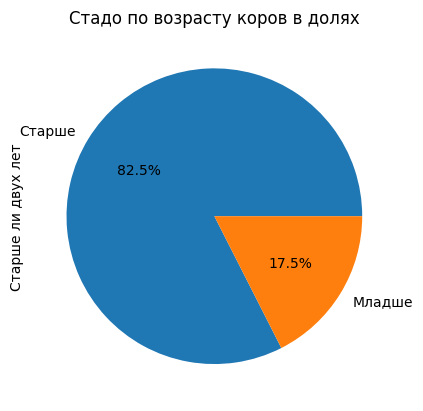

In [64]:
data_main['is_older2'] \
    .value_counts() \
    .rename(index={True: 'Старше', False:'Младше'}) \
    .plot(kind='pie', ylabel='Старше ли двух лет', title='Стадо по возрасту коров в долях', autopct='%1.1f%%');

Мы видим, что доля коров младше двух лет довольна мала.
Вероятно, непосредственный удой она не дает, а присутствует в стаде «на вырост».

### Вывод

Мы видим, что у числовых признаков выбросы были только у трех признаков: yield («Удой»), fat_content («Жирность») и protein («Сырой протеин»).
Только у признака yield («Удой») они носили явно аномальный характер и были удалены.

Среди числовых признаков распределения, отличные от нормального, почти у всех, кроме признака protein («Белок»).
В целом, это вызвано неслучайностью попадания коров в стадо, т.к. их отбирали по максимизации потенциального удоя, а также вкусу молока, которые неким образом зависят от этих числовых признаков.

Например, мы видим, что доля кормов с показателем feed_energy («ЭКЕ») больше 14 выше, нежели аналогичной доли с показателем carb_protein_ratio («ЭКЕ») ниже 14.
Мы видим, что показатель carb_protein_ratio («СПО») фрагментирован.
Возможно, это связано со стандатизацией типов кормов.

Признак fat_content («Жирность») сконцентрирован вокруг значений больше 3.5 (больше половины коров дают молоко такой жирности).
Это может говорить о том, что здоровые коровы, в принципе дают молоко такой жирности, а меньшие показатели жирности — симптом нездоровой коровы.

Среди категориальных признаков, прежде всего, обращает на себя внимание малая доля молодых (с возрастом меньше двух лет) коров в стаде.
По всей видимости, они присутствуют в стаде «на вырост».
Остальные показатели примерно равны, либо перевес небольшой (на 10 процентных пунктов).

В качестве улучшения представленных данных можно предложить выявление связей и возможных функциональных зависимостей внутри самих числовых
признаков, а также влияние категориальных и числовых признаков друг на друга с возможным удалением старых признаков (например, признак protein, вероятнее всего, никак не связан с удоем, с прицелом на который отбирались буренки в стадо) и выработкой неких новых.

## Корреляционный анализ данных

Рассчитаем коэффициенты корреляции между признаками датасета c данными о стаде фермера на данный момент (data_main).

In [65]:
data_main_num_cols = ['yield', 'feed_energy', 'raw_protein', 'carb_protein_ratio', 'fat_content', 'protein']

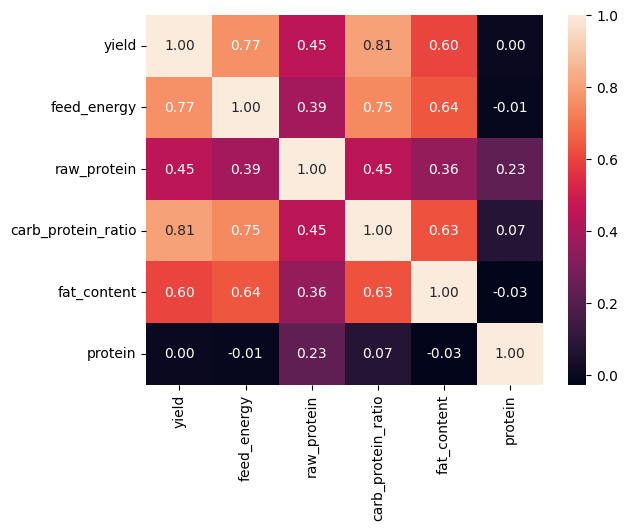

In [66]:
sns.heatmap(data_main[data_main_num_cols].corr(), annot=True, fmt='.2f');

Мы видим, что у целевого признака yield (Удой) самая сильная линейная связь с входными признаками carb_protein_ratio («СПО»), а также feed_energy («ЭКЕ»).
Также наблюдается заметная линейная связь целевого признака с признаком fat_content («Жирность») и умеренная  с признаком raw_protein («сырой протеин»).

Наблюдается также мультиколлинеарность между парой входных признаков feed_energy («ЭКЕ») и carb_protein_ratio («СПО»),
между парой feed_energy («ЭКЕ») и fat_content («Жирность»), а также парой carb_protein_ratio («СПО») и fat_content («Жирность»).

Посмотрим на диаграммы рассеяния удоя коров для различных числовых признаков с учетом каждого из категориальных.

In [67]:
# Функция строительства диаграммы рассеяния удоя коров для произвольного числового признака с учетом категориального
def build_scatter_plot_2(feature, cat_feature=''):
    def cat_feature_kind(kind):
        if cat_feature == 'is_older2':
            return 'Более 2 лет' if kind == True else 'Менее 2 лет'
        elif cat_feature == 'is_delicious':
            return 'Вкусное' if kind == True else 'Невкусное'
        else:
            return kind
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {
        'Айдиал': 'Orange',
        'Соверин': 'Navy',
        'Менее 2 лет': 'Red',
        'Более 2 лет': 'Green',
        'Невкусное': 'Lawngreen', 
        'Вкусное': 'Purple',
        'Холмистое': 'Cyan',
        'Равнинное': 'Magenta',
        'Буйный': 'Orange',
        'Соловчик': 'Navy',
        'Барин': 'Red',
        'Геркулес': 'Green'
    }

    if cat_feature == '':
        data_main.plot(kind='scatter', x=feature, y='yield', color='b', ax=ax)
        return
    
    for kind, data in data_main.groupby(cat_feature):
        data.plot(kind='scatter', x=feature, y='yield', label=cat_feature_kind(kind), color=colors[cat_feature_kind(kind)], ax=ax, alpha=0.4)

    ax.set(xlabel=data_main_cols_dict[feature], ylabel='Удой')
    fig.suptitle(f'Диаграмма рассеяния удоя коров в зависимости от признака «{data_main_cols_dict[feature]}» по категории «{data_main_cols_dict[cat_feature]}»')
    plt.show()

Рассмотрим диаграмму рассеяния признака yield («Удой») от числовых по категориальному признаку breed («Порода»).

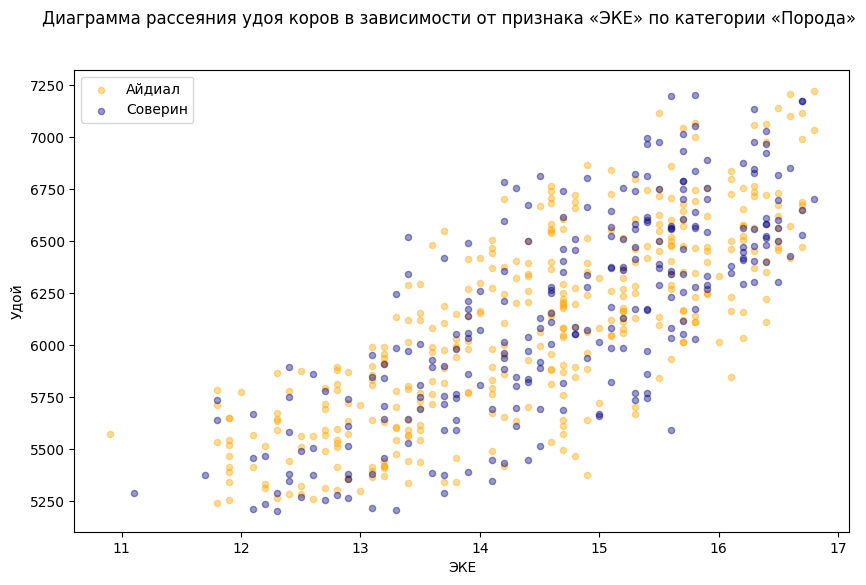

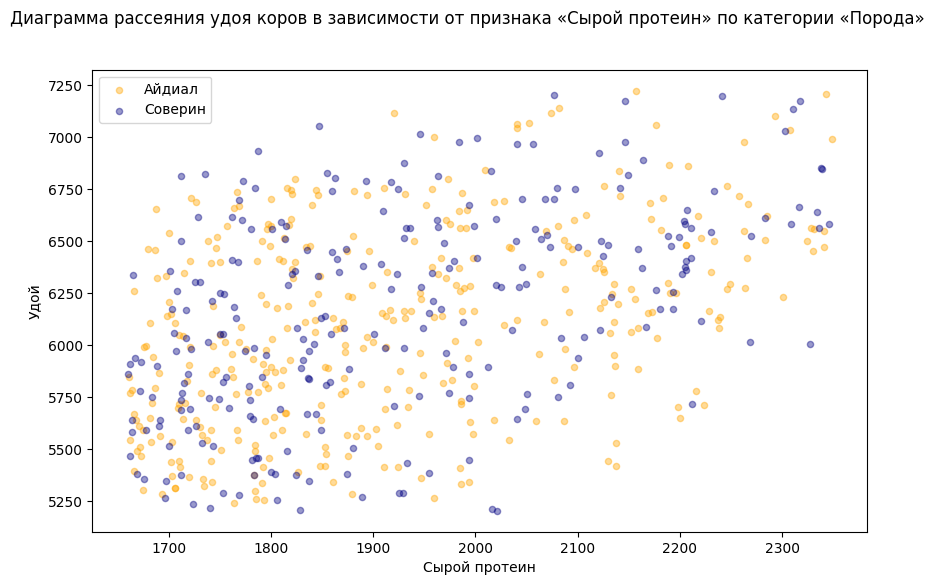

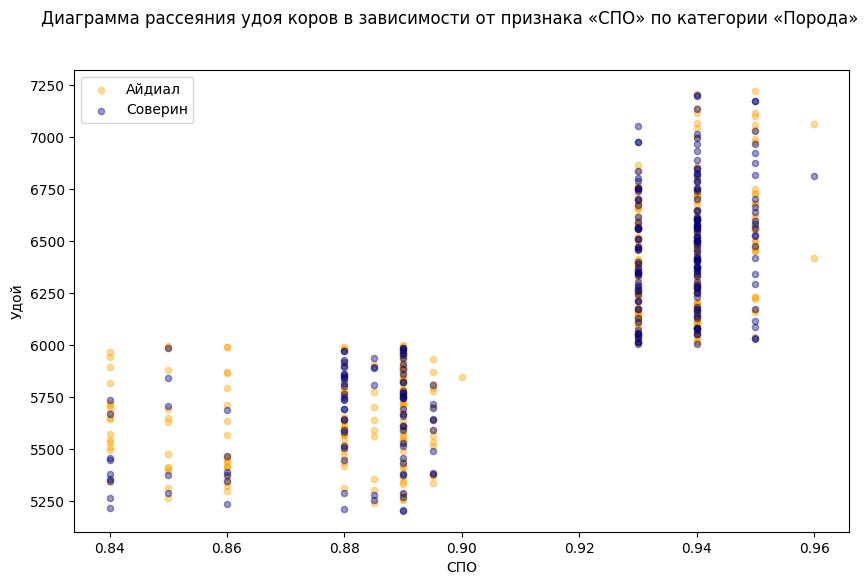

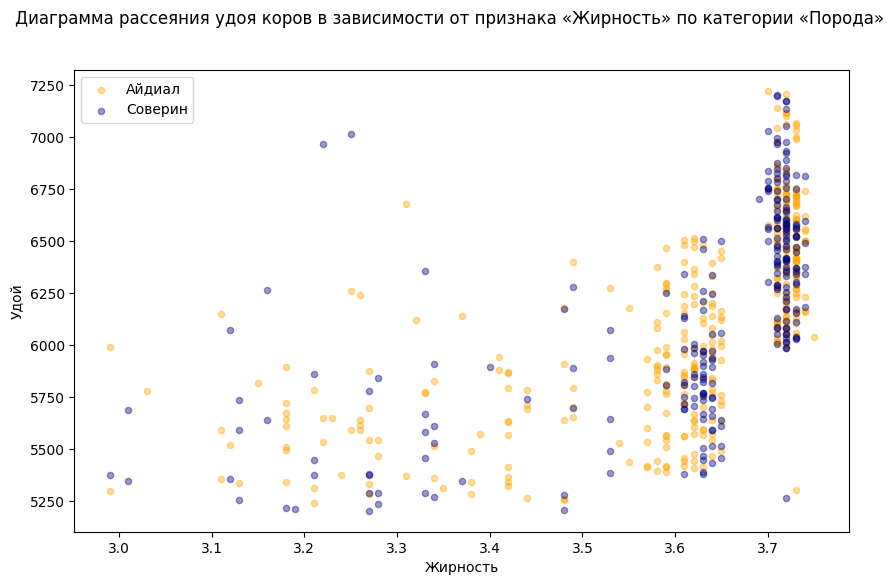

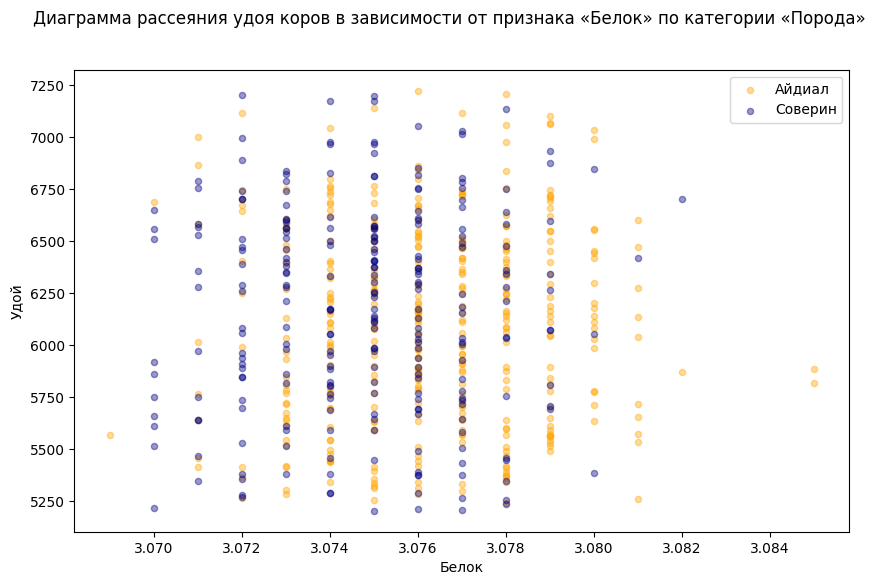

In [68]:
for col in [x for x in data_main_num_cols if x != 'yield']:
    build_scatter_plot_2(col, 'breed')

Никакого дополнительного вида связи в подгруппах породы коров («Айдиал» — «Соверин») не просматривается.

Рассмотрим теперь диаграмму рассеяния признака yield «Удой» от числовых по категории pasture_type («Тип пастбища»).

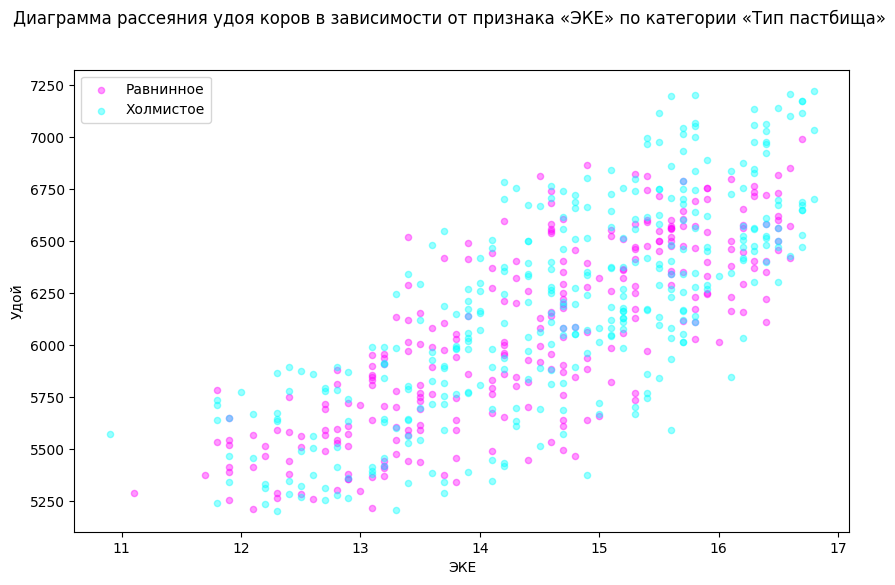

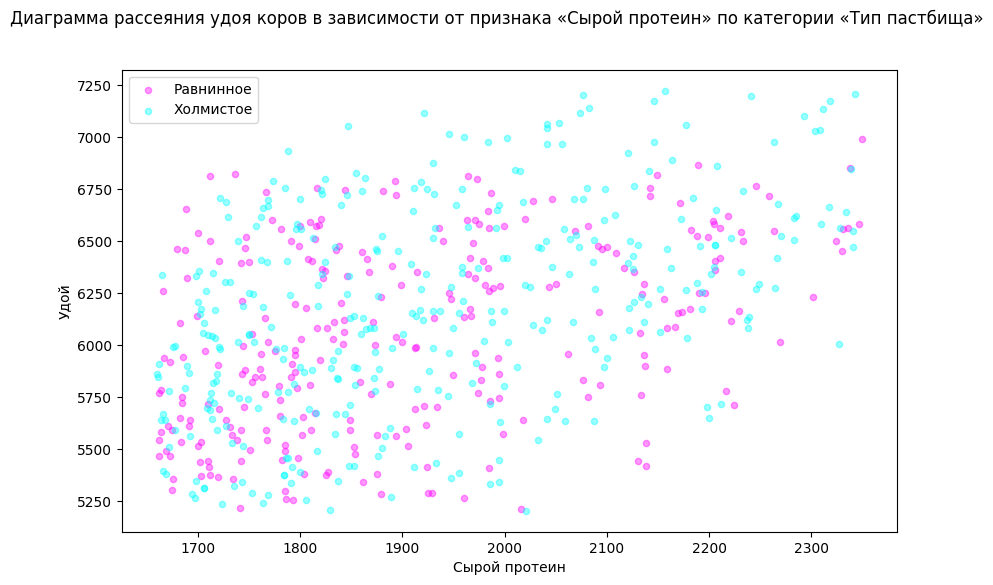

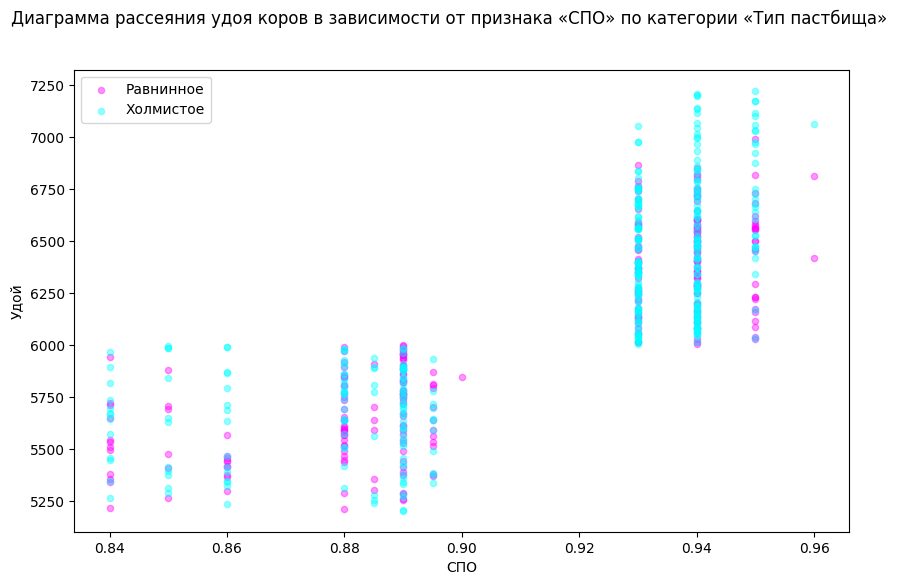

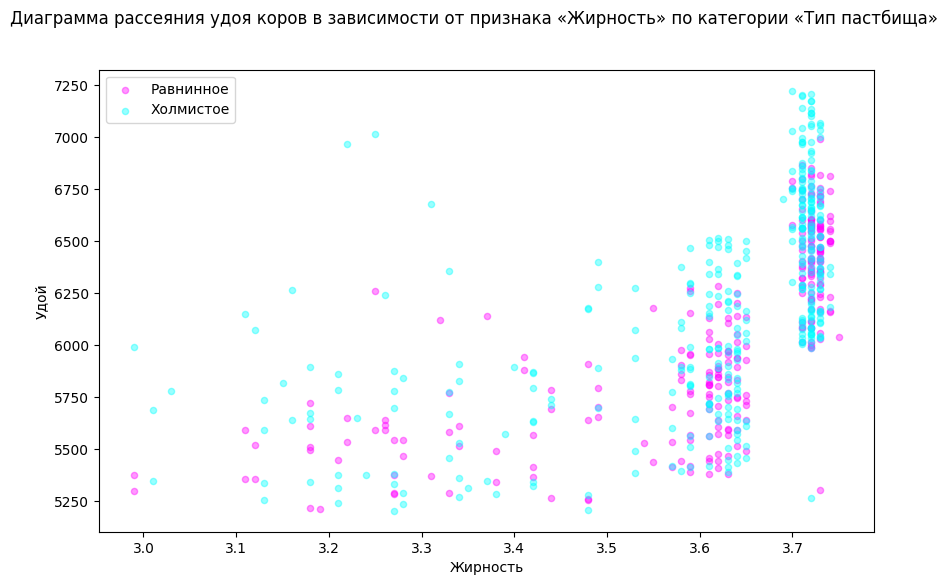

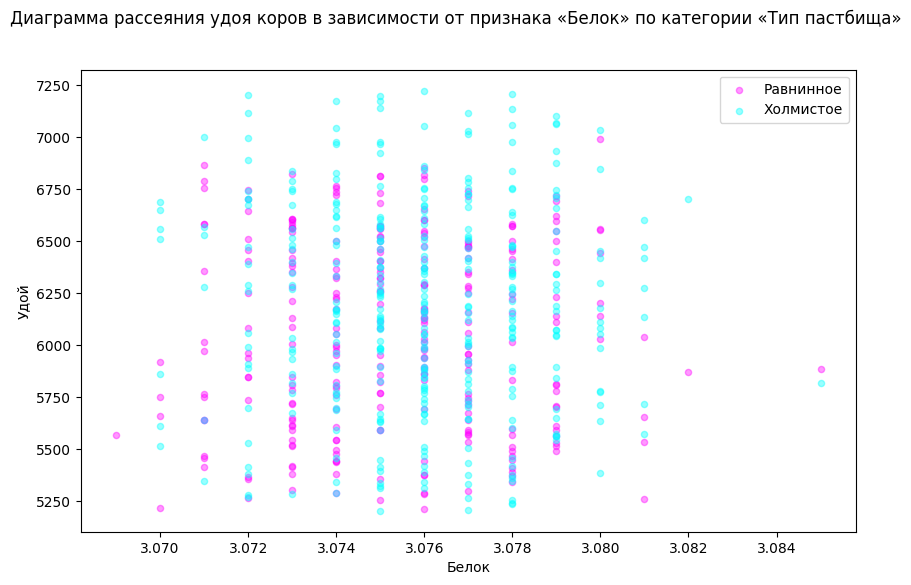

In [69]:
for col in [x for x in data_main_num_cols if x != 'yield']:
    build_scatter_plot_2(col, 'pasture_type')

Никакого дополнительного вида связи в подгруппах по типу пастбища («Равнинное» — «Холмистое») не просматривается.

Рассмотрим диаграмму рассеяния признака yield («Удой») от числовых по категориальному признаку breed_dad («Порода папы»).

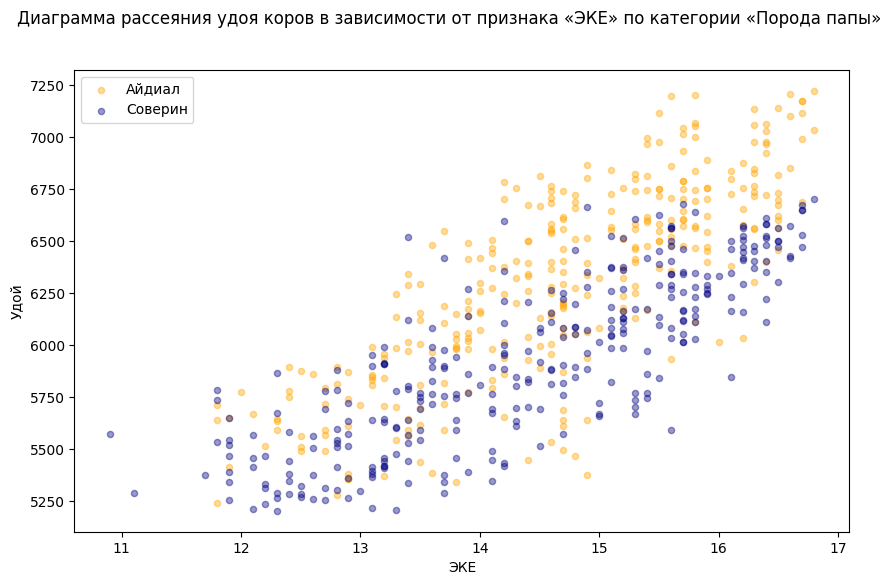

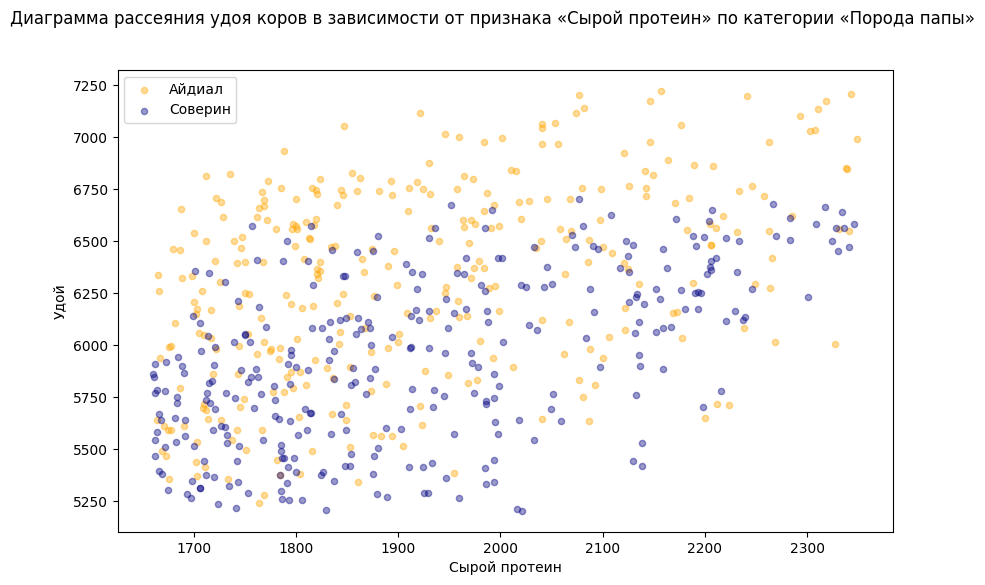

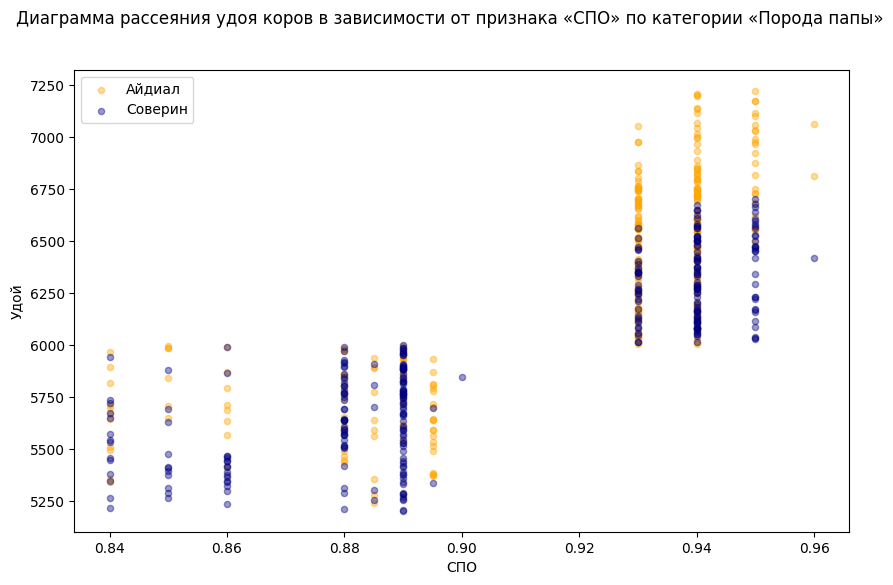

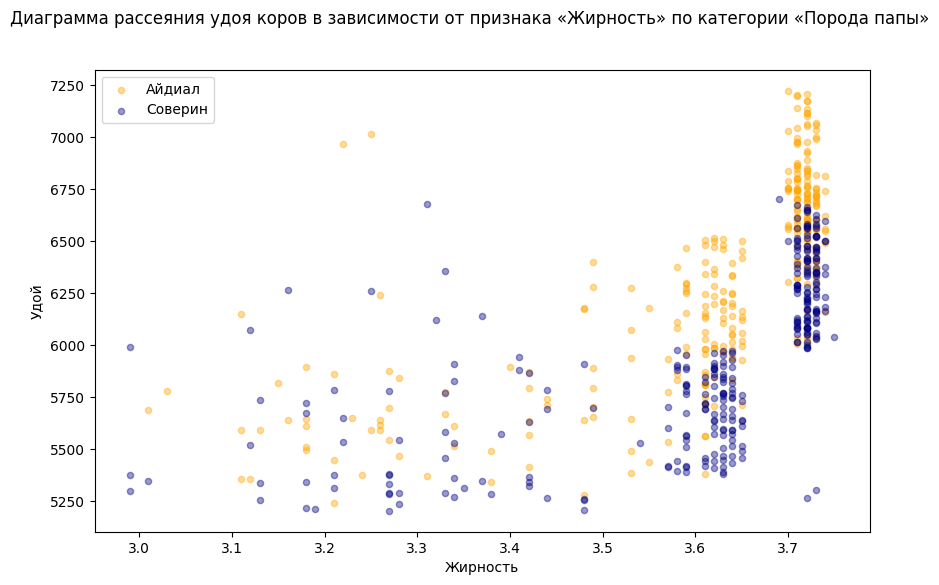

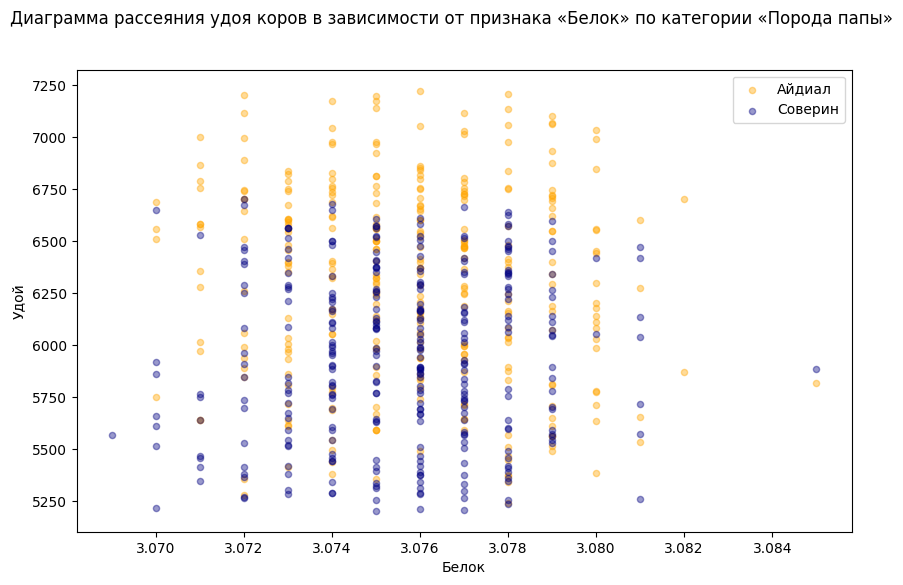

In [70]:
for col in [x for x in data_main_num_cols if x != 'yield']:
    build_scatter_plot_2(col, 'breed_dad')

Мы видим, что порода папы коровы влияет на удой. Построим диаграмму размаха для удоя по породам папы коровы.

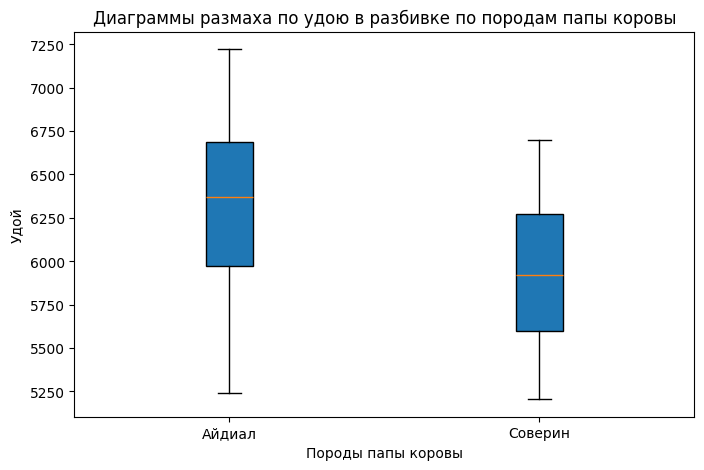

In [71]:
data_main_breed_dad_yield = {}
for breed_dad in data_main['breed_dad'].unique():
    data_main_breed_dad_yield[breed_dad] = data_main.query('breed_dad == @breed_dad')['yield']

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_main_breed_dad_yield.values(), sym='.', patch_artist=True)
ax.set_xticklabels(data_main_breed_dad_yield.keys())
ax.set_title('Диаграммы размаха по удою в разбивке по породам папы коровы')
ax.set_xlabel('Породы папы коровы')
ax.set_ylabel('Удой')
plt.show()

Да, так и есть. Практически $75\%$ выборки с породой папы «Айдиал» лежит выше целевого показателя удоя в 6000 кг, чего нельзя сказать о породе папы «Соверин», где выше 6000 кг расположено меньше половины выборки.
Всего в стаде коров по породам пап примерно поровну.

Посмотрим диаграмму рассеяния удоя в зависимости от числовых признаков по категории «Вкус молока»

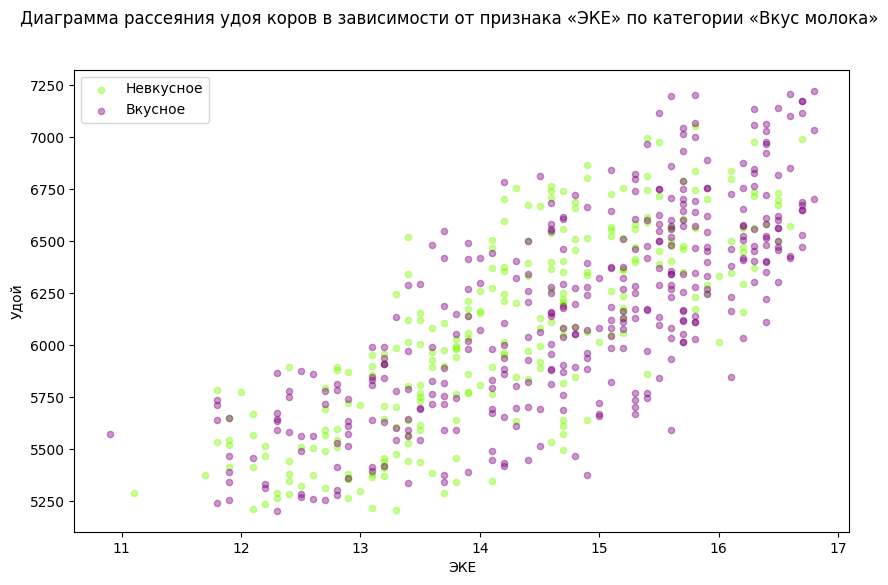

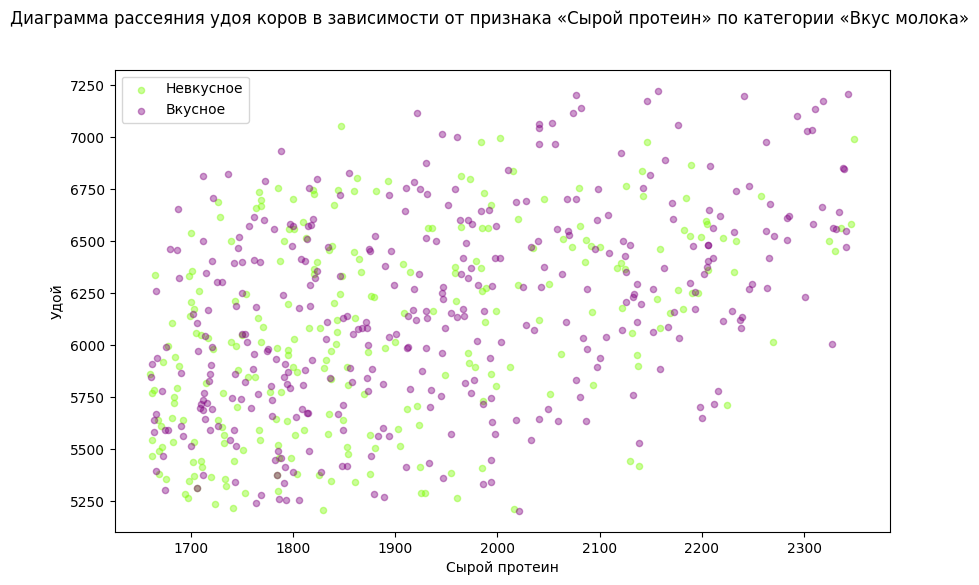

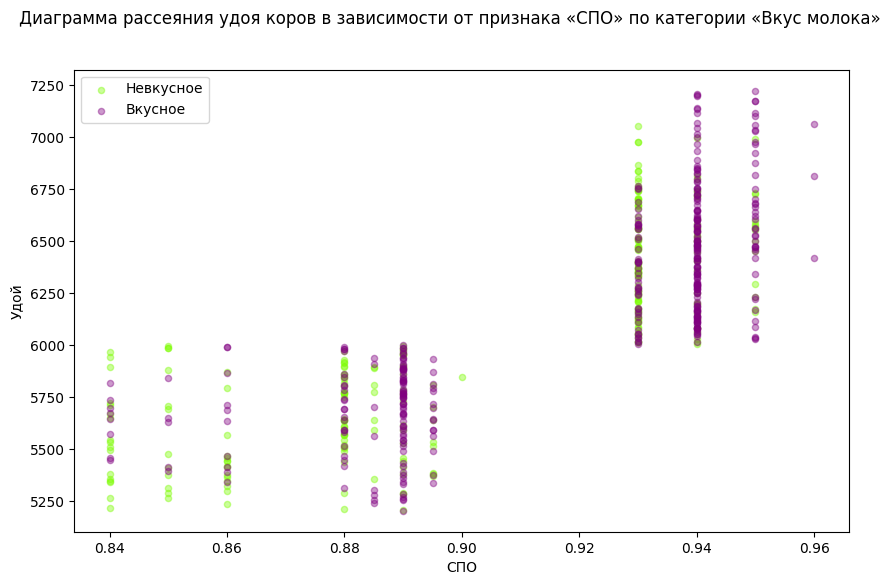

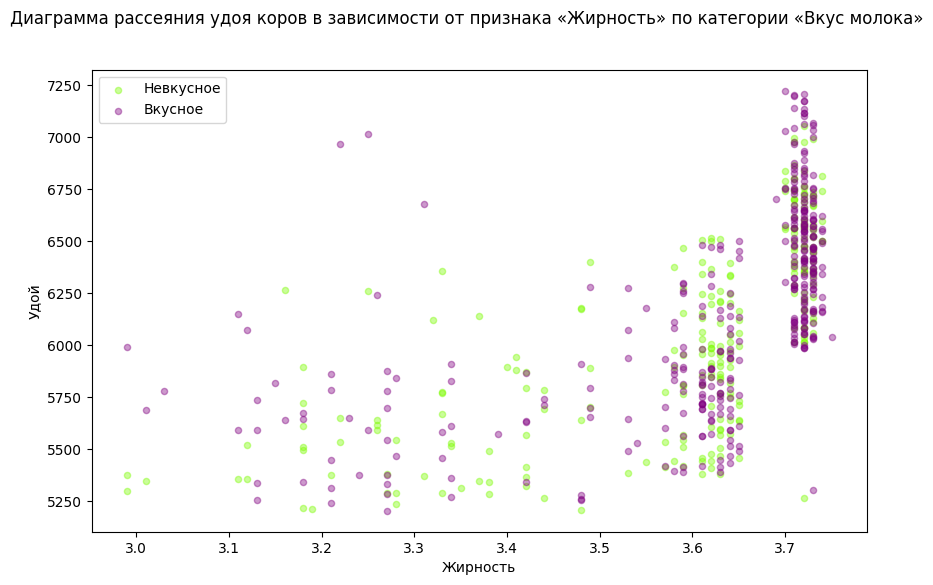

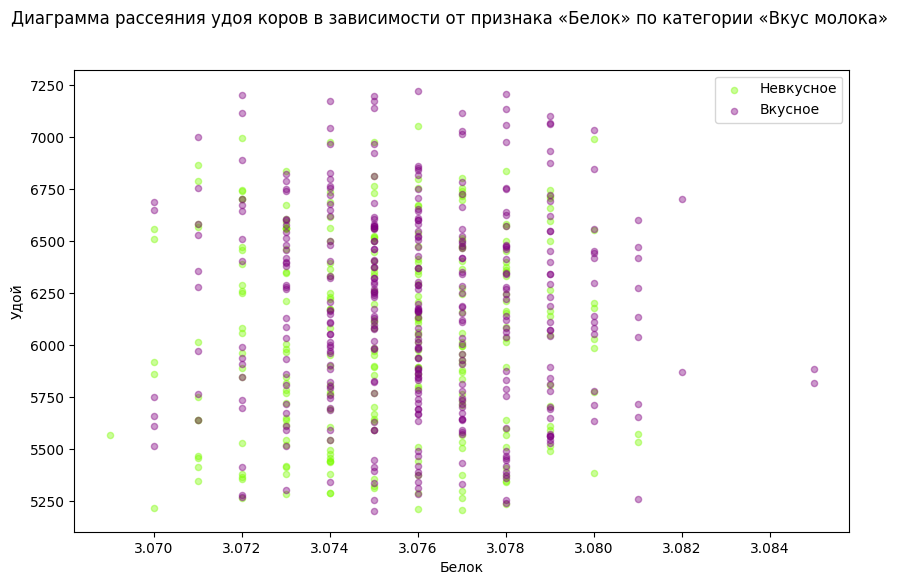

In [72]:
for col in [x for x in data_main_num_cols if x != 'yield']:
    build_scatter_plot_2(col, 'is_delicious')

Никакого дополнительного вида связи в подгруппах вкуса молока («Вкусное» — «Невкусное») не просматривается.

Рассмотрим диаграмму рассеяния признака yield («Удой») от числовых по категориальному признаку is_older2 («Порода папы»).

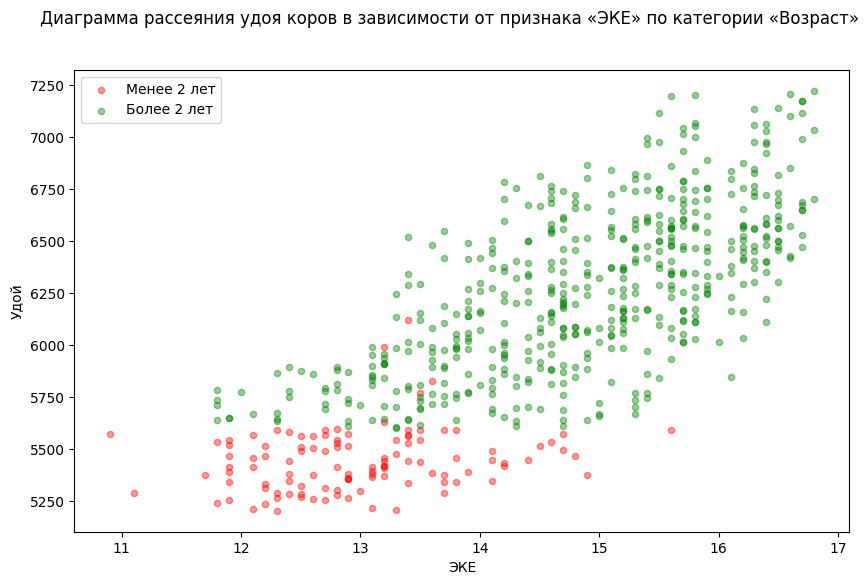

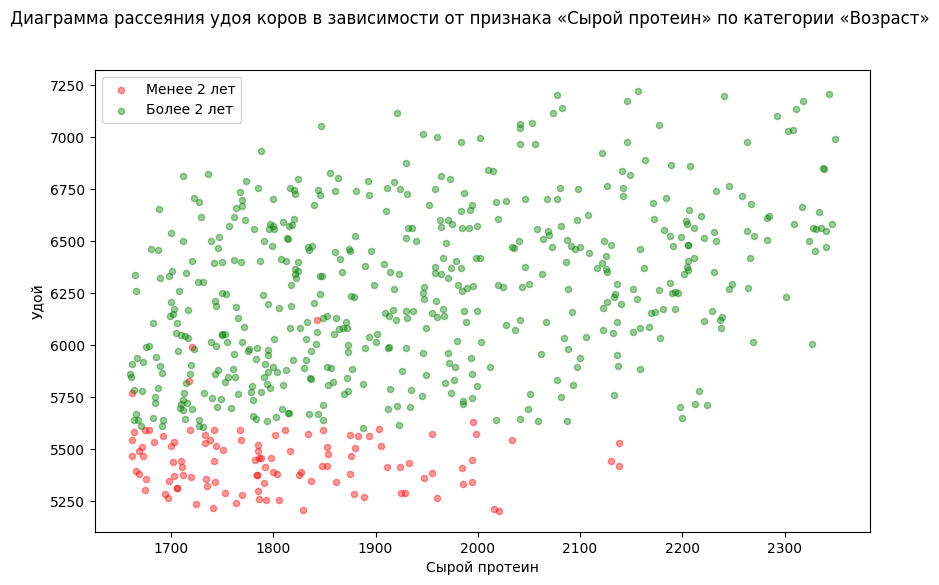

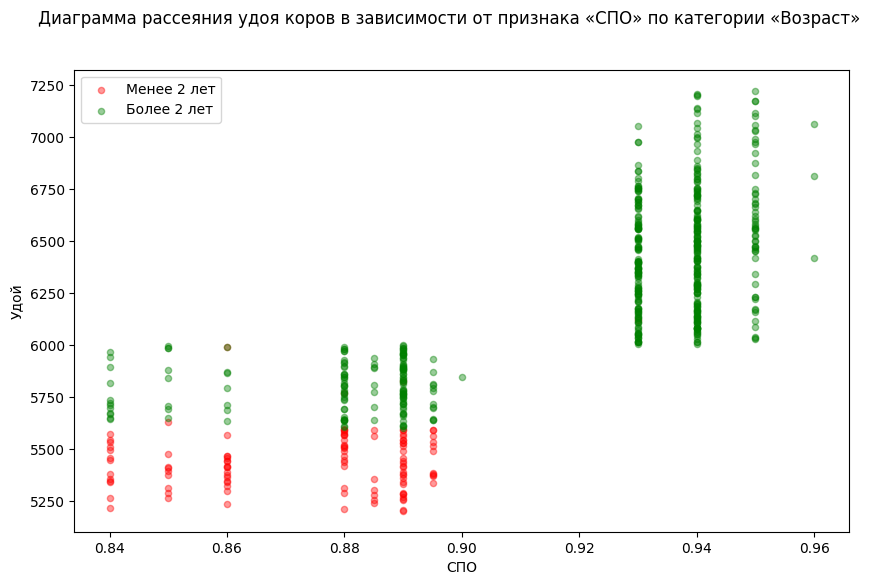

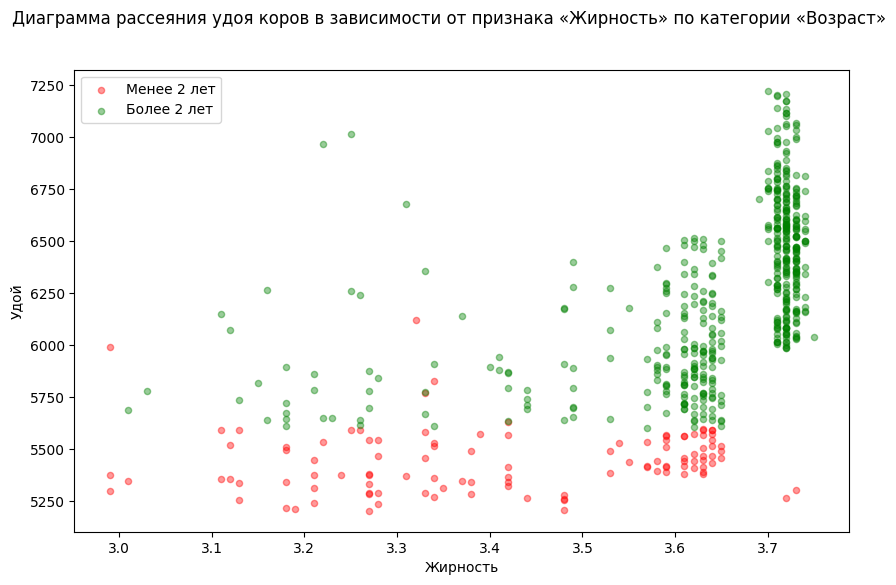

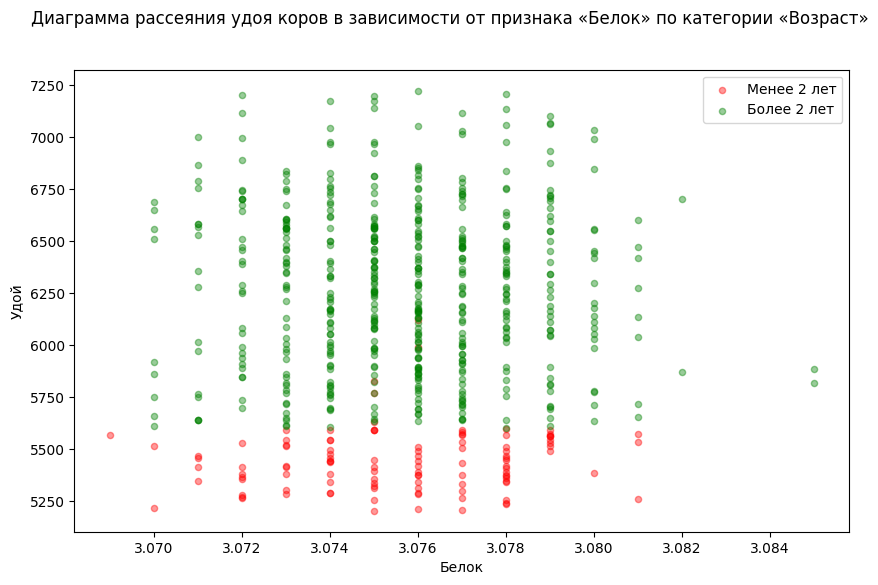

In [73]:
for col in [x for x in data_main_num_cols if x != 'yield']:
    build_scatter_plot_2(col, 'is_older2')

Мы видим, что возраст коровы имеет решающее значение для максимизации удоя.
Фактически весь крупный (свыше 6000 кг) удой дают именно они.
Молодые коровы присутствуют в стаде «на вырост».

#### Общий вывод 

Мы видим связь входного признака «ЭКЕ» и целевого признака «Удой».
Она сохраняет некий общий профиль для каждого из категориальных признаков.
Значения ЭКЕ ниже 13 фактически исключают возможность выхода на целевой показатель признака Удой в 6000 кг.
Если рассмотреть значения ЭКЕ выше 13 для каждого из категориальных признаков, то они укладываются в «раздутый» эллипс (с большими полуосями), что размывает линейный характер зависимости (у сильной линейной зависимости эллипс должен быть с одной большой полуосью, в идеале совпадающей с прямой предполагаемой зависимости, и малой -- другой, т.е. он должен быть как бы «сплющен»).
В целом, говорить о строгом линейном характере зависимости между признаками «ЭКЕ» и «Удой» нельзя.

Связь признака «Сырой протеин» с признаком «Удой» невелика.
Можно лишь говорить, что для среди значений признака «Cырой протеин» выше 2100 большинство коров имеет Удой выше целевого показателя в 6000,
но коров, питавшихся кормом с таким содержанием сырого протеина, исходя из гистрограммы этого признака, немного.

Признак «СПО» фактически является пороговым в нашем датасете.
Данные в датасете, очевидно, разбиваются на 2 кластера.
Все коровы, питавшиеся кормом с СПО 0.93 и выше, имеют удой выше 6000 кг.
Практически все коровы, питавшиеся кормом с СПО 0.90 и ниже, имеют удой ниже 6000 кг.
В роли порога может выступать, например, значения 0.91 или 0.92.
При этом мы видим, что коровы в возрасте менее 2 лет такой корм не потребляют.

С признаком «Жирность» сложная ситуация.
Мы видим, что коров, дающих молоко с «Жирностью» меньше 3.6, мало и зависимости «Удоя» от «Жирности» там нет.
Среди коров, дающих молоко с жирностью выше 3.6, виднеются 2 кластера.
Жирность свыше 3.7 практически гарантирует целевой удой (кроме 2х случаев молодых коров).
Жирность свыше 3.6, но ниже 3.7, делает возможным обе ситуации, но («Удой» может быть как выше целевого, так и ниже)
если дополнительно учитывать, скажем, породу папы коровы, то для породы папы «Соверин» удой почти всегда ниже целевого.

Для признака «Белок» каких-либо зависимостей не выявлено.

## Задача регрессии

### Первая модель

#### Создание выборок

В качестве целевого рассмотрим признак yield (Удой).
Разделим общие данные по столбцам на входные признаки с одной стороны и целевой — с другой.

In [74]:
features = data_main.drop('yield', axis=1)

In [75]:
y = data_main['yield']

#### Отбор признаков

В качестве признаков выберем следующие:
* Из харктеристик коровы — breed_dad («Пород папы коровы») и is_older2 («Возраст»)
* Из характеристик корма — feed_energy («ЭКЕ») и carb_protein_ratio («СПО»)
* Из характеристик пастбища — pasture_type («Тип пастбища»)
* Из характеристик молока — fat_content(«Жирность»).

Из характеристик коровы был исключен признак breed («Порода»), т.к. не выявлено специфического именно для этого признака вида зависимости,
в том числе его влияния на какие-то числовые признаки.
Для признака breed_dad («Порода папы быка») такой вид зависимости, специфичный для данного категориального признака, был обнаружен).
Также важным оказался признак is_older2 («Возраст»).

Из характеристик корма значимыми в смысле потенциальной линейной зависимости с целевым оказались два: feed_energy («ЭКЕ») и carb_protein_ratio
(«СПО»).
Несмотря на формально высокий показатель коллинеарности между ними, было решено оставить оба, т.к., во-первых, у признака
carb_protein_ratio («СПО») более высокий, нежели у feed_energy («ЭКЕ»), показатель коллинеарности с целевым, а во-вторых,
признак carb_protein_ratio («СПО») фактически является категориальным, а не числовым, как feed_energy («ЭКЕ»), поэтому формально высокий
показатель коллинеарности между ними может быть обманчивым.

Признак pasture_type («Тип пастбищ») был включен в перечень признаков для обеспечения репрезентативности категорий признаков
(в отличие признака breed («Порода») из категории «Характеристики коровы», из которой взяты другие признаки) в модели и исходя из базового предположения,
что условия выпаса коров могут влиять на удой, хотя это и не было замечено на диаграммах рассеяния.

Из характеристик молока была выбран признак fat_content («Жирность»), т.к. для него была обнаружена зависимость (общий профиль рассеяния, сохраняющийся при любом чилосовом признаке), хотя и нелинейная.
Для признаков is_delicious («Вкус молока») и protein («Белок») какой-то отчетливой зависимости с целевым признком yield («Удой») не выявлено.

In [76]:
feature_cols = ['breed_dad', 'is_older2', 'feed_energy', 'carb_protein_ratio', 'fat_content', 'pasture_type']

In [77]:
feature_num_cols = ['feed_energy', 'carb_protein_ratio', 'fat_content']

In [78]:
feature_cat_cols = ['breed_dad', 'is_older2', 'pasture_type']

In [79]:
X = features[feature_cols]

#### Создание выборок

Разобьем данные на тренировочную и тестовую выборки.

In [80]:
RANDOM_STATE = 12345

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

Закодируем категориальные признаки.

In [82]:
# В новой версии библиотеки sklearn изменено наименование параметра (не как в теории).
# На всякий случай, добавил оба варианта

In [83]:
try:
    encoder = OneHotEncoder(drop='first', sparse_output=False) 
except:
    encoder = OneHotEncoder(drop='first', sparse=False)

In [84]:
X_train_ohe = encoder.fit_transform(X_train[feature_cat_cols])
X_test_ohe = encoder.transform(X_test[feature_cat_cols])

In [85]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder.get_feature_names_out())

Масштабируем числовые признаки.

In [86]:
scaler = StandardScaler()

In [87]:
X_train_scaled = scaler.fit_transform(X_train[feature_num_cols])
X_test_scaled = scaler.transform(X_test[feature_num_cols])

In [88]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_num_cols)

Объединяем в окончательные выборки.

In [89]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Инициализируем, обучаем модель линейной регрессии.
Получаем предсказание.

In [90]:
model_lr  = LinearRegression()

In [91]:
model_lr.fit(X_train, y_train);

In [92]:
y_pred = model_lr.predict(X_test)

Получаем оценку $R^2$ модели

In [93]:
r2 = r2_score(y_test, y_pred)  

In [94]:
r2

0.80538554219094

#### Оценка остатков

Изучим остатки, построив их распределение.

In [95]:
residuals_m1 = pd.DataFrame({'error': y_test-y_pred, 'prediction': y_pred})

In [96]:
residuals_m1['error'].mean().item()

4.68613547417803

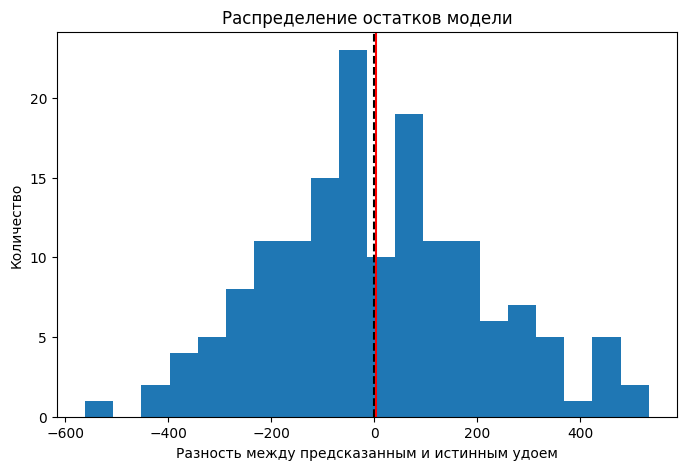

In [97]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(x=residuals_m1['error'], bins=20)
ax.axvline(0, color='k', linestyle='--')
ax.axvline(residuals_m1.error.mean().item(), color='r', linestyle='-')
ax.set_title('Распределение остатков модели')
ax.set_xlabel('Разность между предсказанным и истинным удоем')
ax.set_ylabel('Количество')
plt.show()

На графике виднеется профиль нормального распределения с формально практически отсутствующим смещением.
Также мы видим пика, почти что симметричных относительно нуля.
Однако мы также видим, что на графике присутствует «тяжелый» правый хвост (смещение выше 400), которое компенсирует смещение графика влево.

Исследуем постоянство дисперсии, построив диаграмму рассеяния.

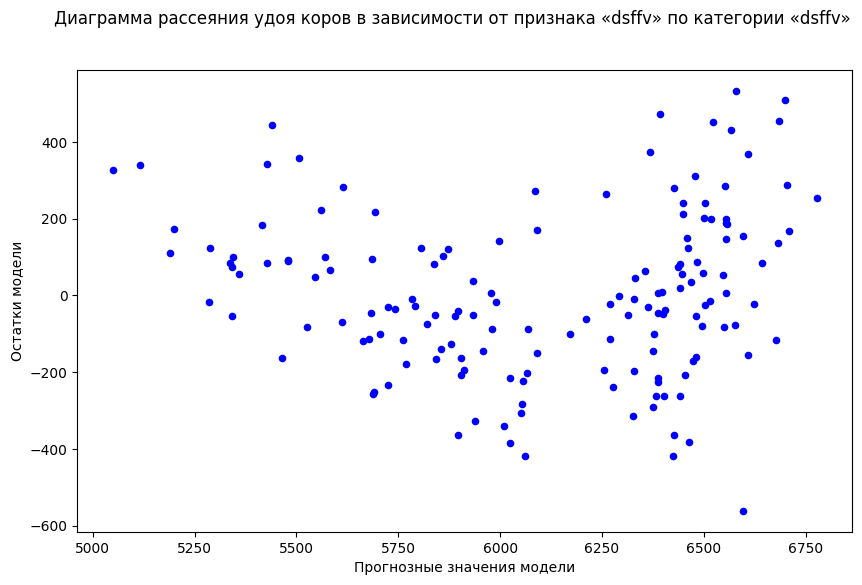

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
residuals_m1.plot(kind='scatter', x='prediction', y='error', ylabel='Остатки модели', xlabel='Прогнозные значения модели', color='b', ax=ax, alpha=1)

fig.suptitle(f'Диаграмма рассеяния удоя коров в зависимости от признака «dsffv» по категории «dsffv»')
plt.show()

#### Вывод

Значение $R^2$ модели — 0.805

Мы видим непостоянство дисперсии остатков: профиль значений левее целевого признака в 6000 явно наклонен, а справа дисперсия достаточно высокая в пределах прогнозных значений 6250 и 6500, далее она немного уменьшается.

Необходимо дальнейший анализ: возможно, на этапе сбора данных не учли какие-то признаки либо необходимо трансформировать нынешние
(например, привести признак carb_protein_ratio («СПО») в явном виде к категориальному).

### Вторая модель

Выше мы увидели, что признак carb_protein_ratio («СПО») по отношению к «Удою» является фактически категориальным бинарным.

Преобразуем его в таковой в явном виде, установив в качестве порога численное значение 0.92 и добавив новый столбец в датасет.

In [99]:
data_main = data_main.assign(carb_protein_ratio_cat=data_main['carb_protein_ratio'].apply(lambda ratio: True if ratio >= 0.92 else False))

Также из анализа диаграмм рассеяния мы увидели, что говорить о сильной линейной связи между признаками feed_energy («ЭКЕ») и yield («Удой»)
не приходится, несмотря на сравнительно высокий коэффициент корреляции.
Тем не менее связь между признаками все же прослеживается, однако носит скорее нелинейный характер.

Постараемся устранить эту нелинейность, введя новый признак feed_energy_squared («ЭКЕ в квадрате»), возведя нынешние значения признака
feed_energy («ЭКЕ») в квадрат.

In [100]:
data_main = data_main.assign(feed_energy_squared=data_main['feed_energy']**2)

In [101]:
features = data_main.drop('yield', axis=1)

Выберем в качестве вжодных те же признаки, что и в первой модели, заменив признак carb_protein_ratio («СПО») на вновь добавленный
carb_protein_ratio_cat («СПО» в категориальном виде), а также feed_energy («ЭКЕ») на feed_energy_squared («ЭКЕ в квадрате»).

In [102]:
feature_cols = ['breed_dad', 'is_older2', 'feed_energy_squared', 'carb_protein_ratio_cat', 'pasture_type', 'fat_content']

In [103]:
feature_num_cols = ['feed_energy_squared', 'fat_content']

In [104]:
feature_cat_cols = ['breed_dad', 'is_older2', 'pasture_type', 'carb_protein_ratio_cat']

In [105]:
X = features[feature_cols]

#### Создание выборок

Разобьем данные на тренировочную и тестовую выборки.

In [106]:
RANDOM_STATE = 12345

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

Закодируем категориальные признаки.

In [108]:
# В новой версии библиотеки sklearn изменено наименование параметра (не как в теории).
# На всякий случай, добавил оба варианта

In [109]:
try:
    encoder = OneHotEncoder(drop='first', sparse_output=False) 
except:
    encoder = OneHotEncoder(drop='first', sparse=False)

In [110]:
X_train_ohe = encoder.fit_transform(X_train[feature_cat_cols])
X_test_ohe = encoder.transform(X_test[feature_cat_cols])

In [111]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder.get_feature_names_out())

Масштабируем числовые признаки.

In [112]:
scaler = StandardScaler()

In [113]:
X_train_scaled = scaler.fit_transform(X_train[feature_num_cols])
X_test_scaled = scaler.transform(X_test[feature_num_cols])

In [114]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_num_cols)

Объединяем в окончательные выборки.

In [115]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Инициализируем, обучаем модель линейной регрессии.
Получаем предсказание.

In [116]:
model_lr  = LinearRegression()

In [117]:
model_lr.fit(X_train, y_train);

In [118]:
y_pred = model_lr.predict(X_test)

In [119]:
r2 = r2_score(y_test, y_pred)  

In [120]:
r2

0.8395143828165971

Видим улучшение оценки на 0.03 единицы.

#### Оценка остатков

Изучим остатки, построив их распределение.

In [121]:
residuals_m2 = pd.DataFrame({'error': y_test-y_pred, 'prediction': y_pred})

Среднее значение ошибки

In [122]:
residuals_m2['error'].mean().item()

11.76477901677733

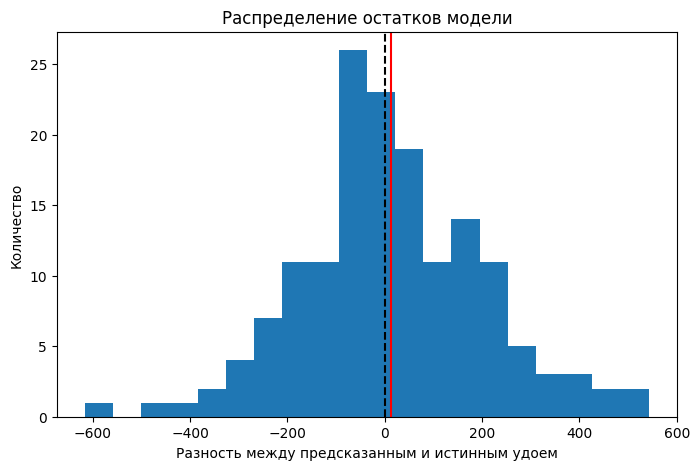

In [123]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(x=residuals_m2['error'], bins=20)
ax.axvline(0, color='k', linestyle='--')
ax.axvline(residuals_m2.error.mean().item(), color='r', linestyle='-')
ax.set_title('Распределение остатков модели')
ax.set_xlabel('Разность между предсказанным и истинным удоем')
ax.set_ylabel('Количество')
plt.show()

Формально на средняя ошибка чуть увеличилась, но доля лучших предсказаний увеличилась.
Небольшое смещение вправо обусловлено «тяжелым» хвостом.

Исследуем постоянство дисперсии, построив диаграмму рассеяния.

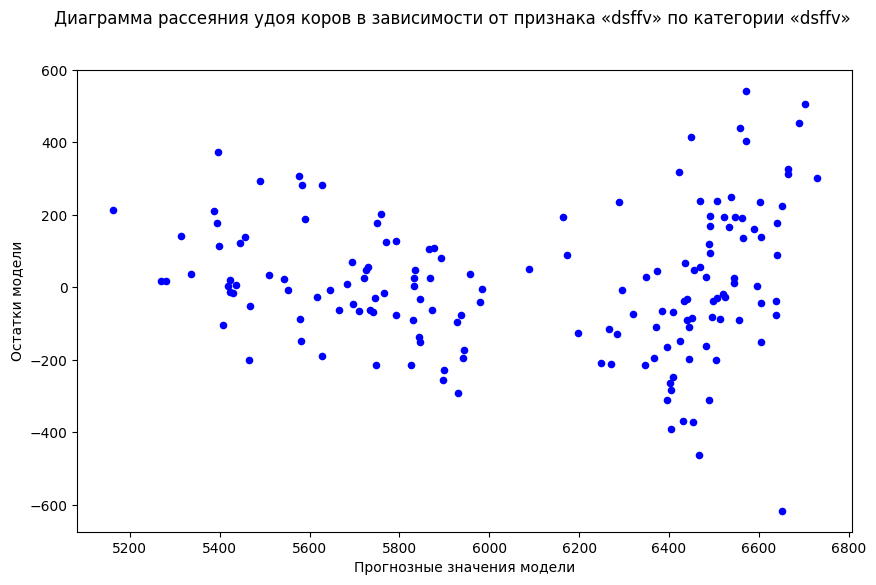

In [124]:
fig, ax = plt.subplots(figsize=(10, 6))
residuals_m2.plot(kind='scatter', x='prediction', y='error', ylabel='Остатки модели', xlabel='Прогнозные значения модели', color='b', ax=ax, alpha=1)

fig.suptitle(f'Диаграмма рассеяния удоя коров в зависимости от признака «dsffv» по категории «dsffv»')
plt.show()

#### Вывод

Значение $R^2$ модели равно 0.837 — выше на 3 десятых, чем в первой модели.

Мы видим, что по сравнению с первой моделью дисперсия слева от целевого значения признака yield («Удой») в 6000 кг стала более стабильной (меньше виднеется наклон).
У правой части (удой выше 6000 кг) дисперсия по-прежнему большая.

Необходим дальнейший анализ популяции коров с удоем выше 6000 кг, т.к. дисперсия сравнительно высокая и видеется наклоненный профиль.

### Третья модель

Объединим основной датасет с признаком 

In [125]:
data_main = data_main.merge(data_dad, on='id', how='inner')

Посмотрим, влияет ли конкретный папа буренки на удой (а не только его порода).

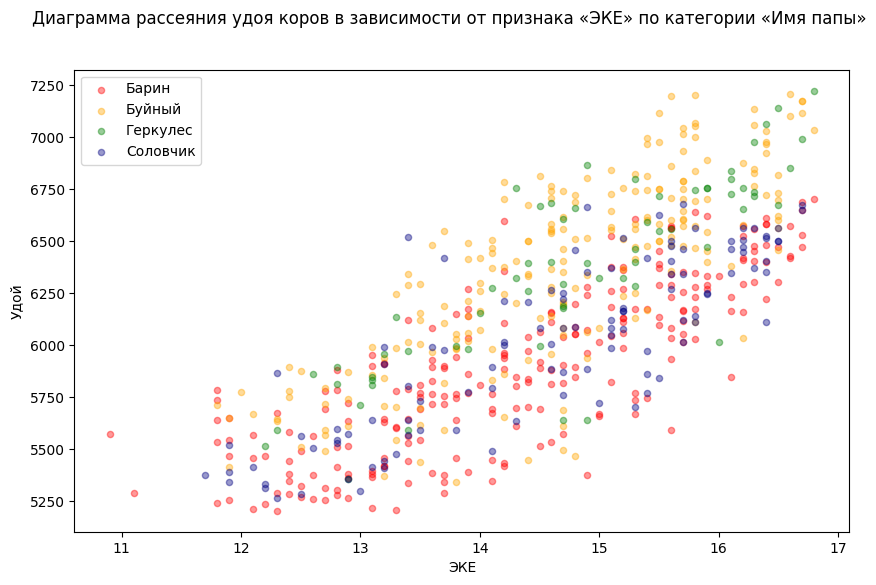

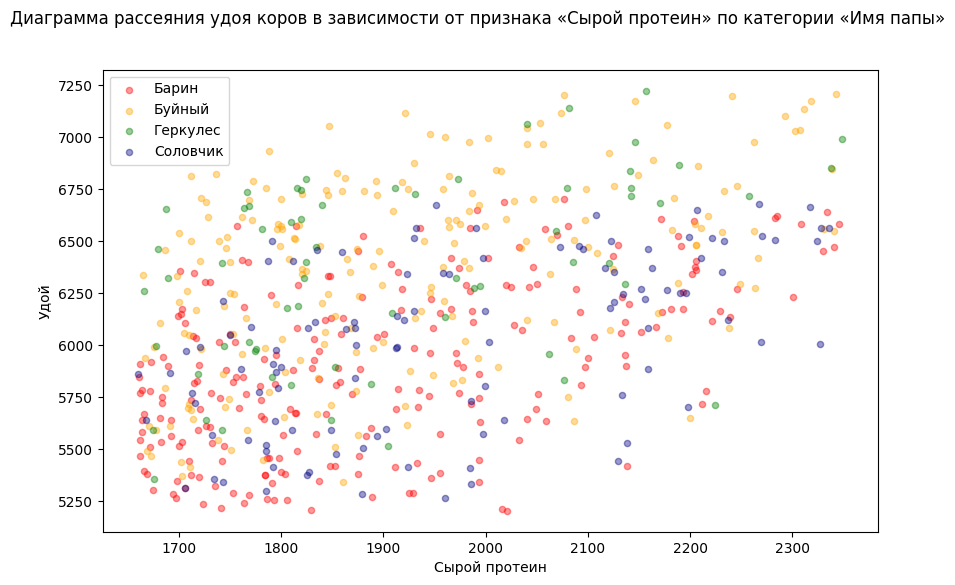

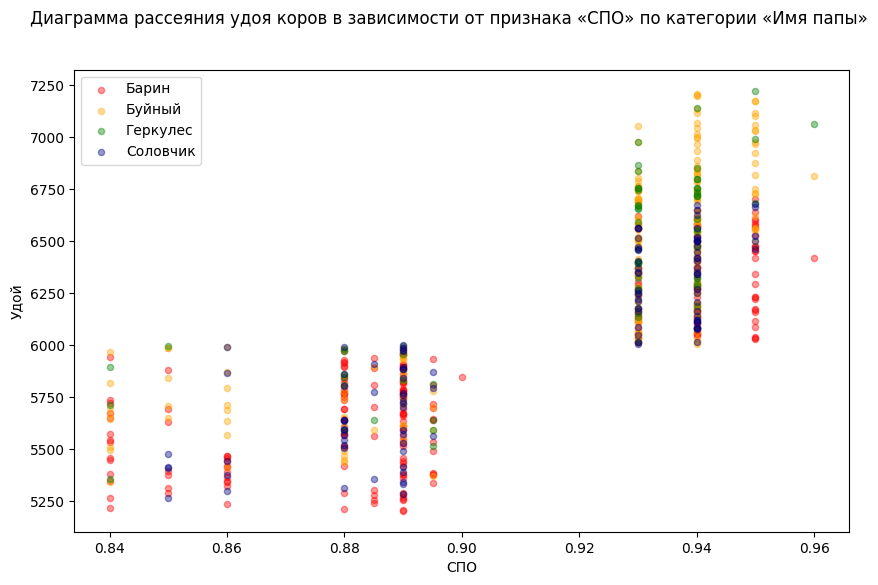

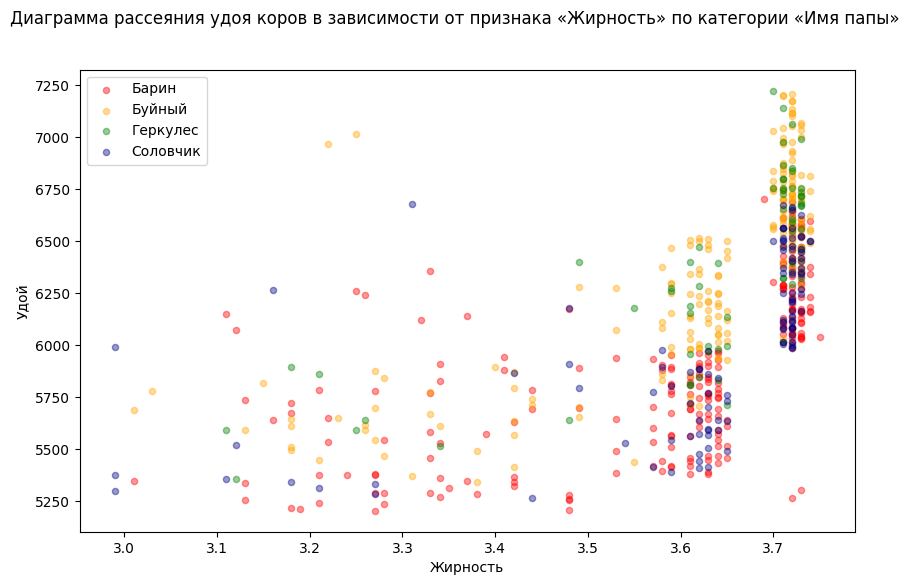

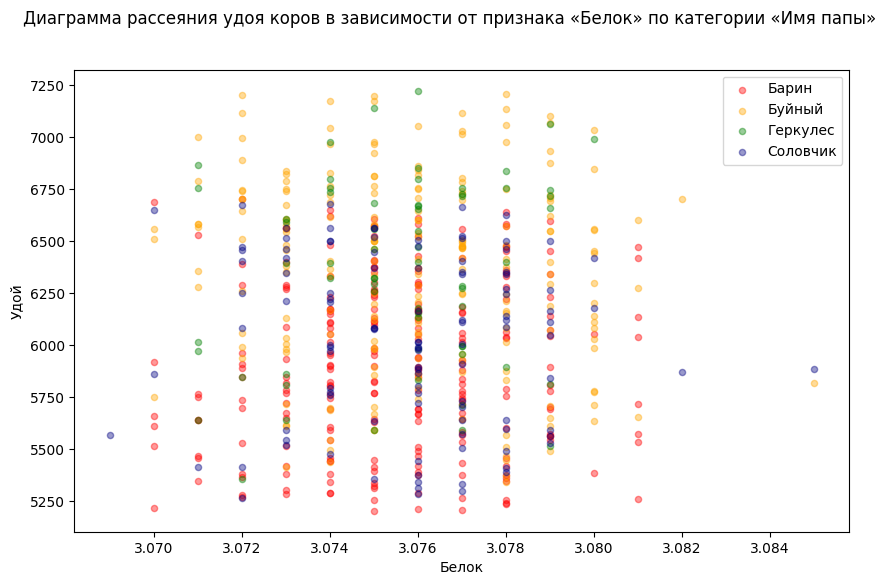

In [126]:
for col in [x for x in data_main_num_cols if x != 'yield']:
    build_scatter_plot_2(col, 'name_dad')

На графиках виднеется категориальная закономерность: коровы от папы «Буйный» и «Геркулес» как будто бы дают больше молока, нежели коровы
от папы «Барин» и «Соловчик» (желтые точки распределены в среднем выше всех, потом зеленые, а ниже всего красные и синие).

Посмотрим на диаграмму размаха.

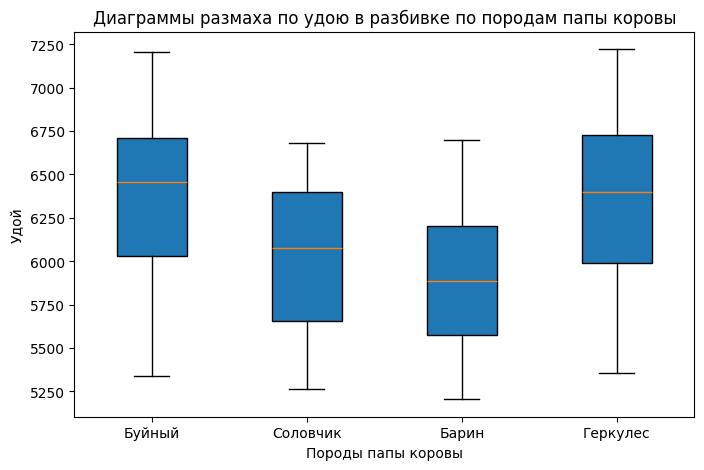

In [127]:
data_main_name_dad_yield = {}
for name_dad in data_main['name_dad'].unique():
    data_main_name_dad_yield[name_dad] = data_main.query('name_dad == @name_dad')['yield']

fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(data_main_name_dad_yield.values(), sym='.', patch_artist=True)
ax.set_xticklabels(data_main_name_dad_yield.keys())
ax.set_title('Диаграммы размаха по удою в разбивке по породам папы коровы')
ax.set_xlabel('Породы папы коровы')
ax.set_ylabel('Удой')
plt.show()

Да, так и есть.
Мы видим, что у 75% коров с именем папы «Буйный» и «Геркулес» удой выше целевого в 6000 кг, а также есть коровы с удоем выше 7000 кг.
У коров с папой «Соловчик» удой выше целевого лишь в чуть более, чем в половине случаев, а у коров с именем папы «Барин» — менее половины.
У четверти коров с именем папы «Буйный» и «Геркулес» удой выше максимального в выборке для коров с именем папы «Соловчик» и «Барин».

Таким образом, имя папы коровы — важный категориальный признак.

Добавим его в список признаков.

In [128]:
features = data_main.drop('yield', axis=1)

Построим модель с учетом его.

In [129]:
feature_cols = ['breed_dad', 'name_dad', 'is_older2', 'feed_energy_squared', 'carb_protein_ratio_cat', 'pasture_type', 'fat_content']

In [130]:
feature_num_cols = ['feed_energy_squared', 'fat_content']

In [131]:
feature_cat_cols = ['breed_dad', 'is_older2', 'pasture_type', 'carb_protein_ratio_cat', 'name_dad']

In [132]:
X = features[feature_cols]

#### Создание выборок

Разобьем данные на тренировочную и тестовую выборки.

In [133]:
RANDOM_STATE = 12345

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

Закодируем категориальные признаки.

In [135]:
# В новой версии библиотеки sklearn изменено наименование параметра (не как в теории).
# На всякий случай, добавил оба варианта

In [136]:
try:
    encoder_3_lr = OneHotEncoder(drop='first', sparse_output=False) 
except:
    encoder_3_lr = OneHotEncoder(drop='first', sparse=False)

In [137]:
X_train_ohe = encoder_3_lr.fit_transform(X_train[feature_cat_cols])
X_test_ohe = encoder_3_lr.transform(X_test[feature_cat_cols])

In [138]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_3_lr.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_3_lr.get_feature_names_out())

Масштабируем числовые признаки.

In [139]:
scaler_3_lr = StandardScaler()

In [140]:
X_train_scaled = scaler_3_lr.fit_transform(X_train[feature_num_cols])
X_test_scaled = scaler_3_lr.transform(X_test[feature_num_cols])

In [141]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_num_cols)

Объединяем в окончательные выборки.

Инициализируем, обучаем модель линейной регрессии.
Получаем предсказание.

In [142]:
model_3_lr  = LinearRegression()

In [144]:
model_3_lr.fit(X_train, y_train);

ValueError: could not convert string to float: 'Айдиал'

In [145]:
y_pred = model_3_lr.predict(X_test)

ValueError: could not convert string to float: 'Соверин'

In [146]:
r2 = r2_score(y_test, y_pred)  

In [147]:
r2

0.8395143828165971

Видим дальнейшее улучшение оценки еще почти на 2 сотых.

#### Оценка остатков

In [148]:
residuals_m3 = pd.DataFrame({'error': y_test-y_pred, 'prediction': y_pred})

In [149]:
residuals_m3['error'].mean().item()

11.76477901677733

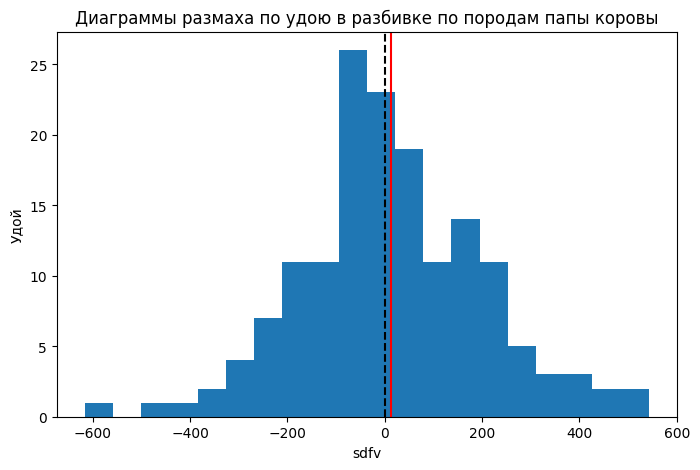

In [150]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(x=residuals_m3['error'], bins=20)
ax.axvline(0, color='k', linestyle='--')
ax.axvline(residuals_m3.error.mean().item(), color='r', linestyle='-')
ax.set_title('Диаграммы размаха по удою в разбивке по породам папы коровы')
ax.set_xlabel('sdfv')
ax.set_ylabel('Удой')
plt.show()

На графике видим, что мода практически выравнилась около значения 0 (значит, значения с минимальной ошибкой встречается чаще всего).

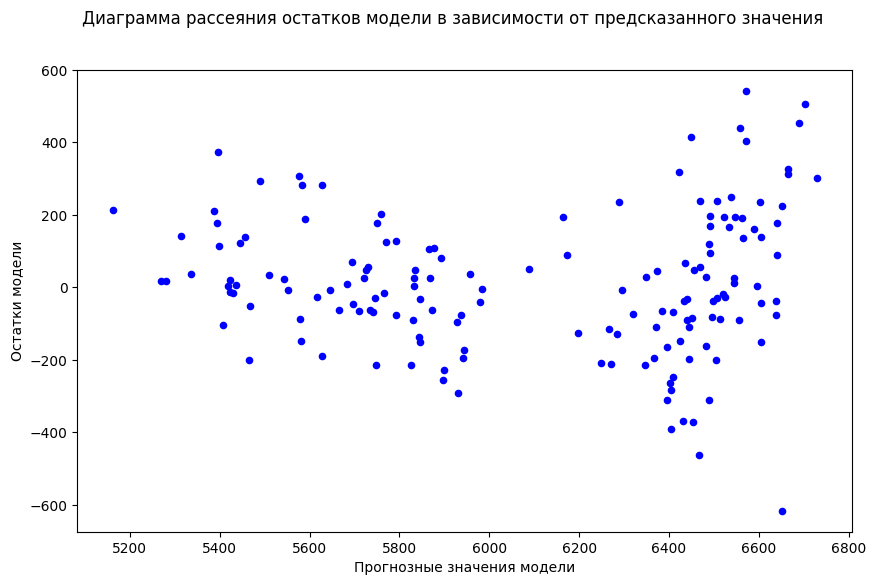

In [151]:
fig, ax = plt.subplots(figsize=(10, 6))
residuals_m3.plot(kind='scatter', x='prediction', ylabel='Остатки модели', xlabel='Прогнозные значения модели', y='error', color='b', ax=ax, alpha=1)

# ax.set(xlabel=data_main_cols_dict[feature], ylabel='Удой')
fig.suptitle(f'Диаграмма рассеяния остатков модели в зависимости от предсказанного значения')
plt.show()

Картина в целом та же, что и у второй модели.

#### Вывод

Из сравнения моделей по $R^2$ мы видим, что качество каждой новой модели увеличивалось.
Это связано со следующими обстоятельствами:
* Преобразованием текущих признаков в качественно новый вид, отражающий их сущность (carb_protein_ratio («СПО») фактически категориальный признак)
* Борьба с нелинейным характером зависимости признака с целевым признаком.
* Добавление нового признака, не присутствовашего в выборке ранее

Из анализа остатков, глядя на распределение, для каждой новой модели мы видим, что значения группируются и уплотняются вокруг нулевого значения ошибки (это говорит об увеличении качества модели), для третьей модели мы видим, что мода находится около нулевого значения ошибки.

#### Оценка качества моделей

##### MSE

###### Первая модель

In [152]:
mean_squared_error(y_test, residuals_m1['prediction'])

np.float64(44411.279505405284)

###### Вторая модель

In [153]:
mean_squared_error(y_test, residuals_m2['prediction'])

np.float64(36623.03243843468)

###### Третья модель

In [154]:
mean_squared_error(y_test, residuals_m3['prediction'])

np.float64(36623.03243843468)

##### MAE

###### Первая модель

In [155]:
mean_absolute_error(y_test, residuals_m1['prediction'])

np.float64(168.23177704164337)

###### Вторая модель

In [156]:
mean_absolute_error(y_test, residuals_m2['prediction'])

np.float64(146.2769481229554)

###### Третья модель

In [157]:
mean_absolute_error(y_test, residuals_m3['prediction'])

np.float64(146.2769481229554)

##### RMSE

###### Первая модель

In [158]:
# Примечание: в новой версии библиотеки sklearn вычисление RMSE будет производится иначе (не как указано в теории)
# На всякий случай, добавил оба варианта.

In [159]:
try:
    rmse = mean_squared_error(y_test, residuals_m1['prediction'], squared=False)
except:
    rmse = root_mean_squared_error(y_test, residuals_m1['prediction'])

rmse

/usr/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(210.7398384392597)

###### Вторая модель

In [160]:
try:
    rmse = mean_squared_error(y_test, residuals_m2['prediction'], squared=False)
except:
    rmse = root_mean_squared_error(y_test, residuals_m2['prediction'])

rmse

/usr/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(191.3714514718292)

###### Третья модель

In [161]:
try:
    rmse = mean_squared_error(y_test, residuals_m3['prediction'], squared=False)
except:
    rmse = root_mean_squared_error(y_test, residuals_m3['prediction'])

rmse

/usr/lib64/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(191.3714514718292)

##### Вывод

Мы видим, что по всем трем метрикам лучшая модель — третья.

###### Доверительный интервал

Рассчитаем для лучшей (третьей) модели доверительный интервал прогноза.

In [162]:
residuals_m3_train = pd.DataFrame({'errors_train': y_train - model_3_lr.predict(X_train)})

ValueError: could not convert string to float: 'Айдиал'

Для этого рассчитаем квантили ошибки на тренировочных данных.

$q_{0,025}$ (0.025й квантиль)

In [163]:
np.quantile(residuals_m3_train, 0.025)

NameError: name 'residuals_m3_train' is not defined

$q_{0,975}$ (0.975й квантиль)

In [164]:
np.quantile(residuals_m3_train, 0.975)

NameError: name 'residuals_m3_train' is not defined

Доверительный интервал прогноза:

($\tilde y$ - $|q_{0,025}|$, $\tilde y$ + $|q_{0,975}|$)

где $\tilde y$ — прогнозное значение.

##### Прогноз удоя коров с помощью лучшей модели

In [165]:
data_cow = data_cow_arch

Добавим недостающие признаки feed_energy («ЭКЕ»), raw_protein («Сырой протеин») и carb_protein_ratio («СПО»), взяв для каждого из них средние значения из датасета со стадом фермера и увеличив их на $5\%$

In [166]:
data_cow = data_cow.assign(feed_energy=data_main['feed_energy'].mean()*1.05)

In [167]:
data_cow = data_cow.assign(raw_protein=data_main['raw_protein'].mean()*1.05)

In [168]:
data_cow = data_cow.assign(carb_protein_ratio=data_main['carb_protein_ratio'].mean()*1.05)

###### Подготовка данных

Подготовим данные, чтобы они соответствовали тренировочным данным для третьей модели, на которых она была обучена.

Добавим признаки feed_energy_squared («ЭКЕ в квадрате»), carb_protein_ratio_cat («СПО», преобразованный в категориальный тип), а также
fat_content («Жирность», это фактически переименованный fat_content_curr, «Текущая жирность»).

In [169]:
data_cow = data_cow.assign(feed_energy_squared=data_cow['feed_energy']**2)

In [170]:
data_cow = data_cow.assign(carb_protein_ratio_cat=data_cow['carb_protein_ratio'].apply(lambda ratio: True if ratio >= 0.92 else False))

In [171]:
data_cow = data_cow.assign(fat_content=data_cow['fat_content_curr'])

Рассмотрим признаки

In [172]:
feature_cols = ['breed_dad', 'name_dad', 'is_older2', 'feed_energy_squared', 'carb_protein_ratio_cat', 'pasture_type', 'fat_content']

In [173]:
feature_num_cols = ['feed_energy_squared', 'fat_content']

In [174]:
feature_cat_cols = ['breed_dad', 'is_older2', 'pasture_type', 'carb_protein_ratio_cat', 'name_dad']

In [175]:
X = data_cow[feature_cols]

Закодируем категориальные признаки

In [176]:
X_ohe = encoder_3_lr.transform(X[feature_cat_cols])

In [177]:
X_ohe = pd.DataFrame(X_ohe, columns=encoder_3_lr.get_feature_names_out())

Масштабируем числовые признаки.

In [178]:
X_train_scaled = scaler_3_lr.transform(X[feature_num_cols])

In [179]:
X_scaled = pd.DataFrame(X_train_scaled, columns=feature_num_cols)

Объединяем в окончательные выборки.

In [180]:
X = pd.concat([X_ohe, X_scaled], axis=1)

Получаем прогноз

In [181]:
y_yield_pred = model_3_lr.predict(X)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- breed_dad_Соверин
- carb_protein_ratio_cat_True
- is_older2_True
- name_dad_Буйный
- name_dad_Геркулес
- ...
Feature names seen at fit time, yet now missing:
- breed_dad
- carb_protein_ratio_cat
- is_older2
- name_dad
- pasture_type


Взглянем на список с коровами, добавив в него получившийся прогноз.

In [182]:
data_cow_temp = data_cow_arch

In [183]:
data_cow_temp.assign(yield_pred=y_yield_pred)

NameError: name 'y_yield_pred' is not defined

Видим, что прогноз по всем коровам выше целевого в 6000 кг, однако это еще не окончательная рекомендация фермеру.

### Задача классификации

Загрузим оригинальные, но предобработанные данные.

In [184]:
data_main = data_main_arch

Добавим в датасет имя отца папы из другого датасета.

In [185]:
data_main = data_main.merge(data_dad, on='id', how='inner')

Разделим данные на признаковые и целевой.

In [186]:
features = data_main.drop('is_delicious', axis=1)

In [187]:
y = data_main['is_delicious'].map({True: 1, False: 0})

Выделим нужные нам для обучения признаки

In [188]:
feature_cols = ['pasture_type', 'breed', 'name_dad', 'carb_protein_ratio']

In [189]:
feature_num_cols = ['carb_protein_ratio']

In [190]:
feature_cat_cols = ['pasture_type', 'breed', 'name_dad']

In [191]:
X = data_main[feature_cols]

#### Создание выборок

Разобьем данные на тренировочную и тестовую выборки.

In [192]:
RANDOM_STATE = 12345

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

Закодируем категориальные признаки.

In [194]:
# В новой версии библиотеки sklearn изменено наименование параметра (не как в теории).
# На всякий случай, добавил оба варианта

In [195]:
try:
    encoder_logr = OneHotEncoder(drop='first', sparse_output=False) 
except:
    encoder_logr = OneHotEncoder(drop='first', sparse=False)

In [196]:
X_train_ohe = encoder_logr.fit_transform(X_train[feature_cat_cols])
X_test_ohe = encoder_logr.transform(X_test[feature_cat_cols])

In [197]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_logr.get_feature_names_out())
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_logr.get_feature_names_out())

Масштабируем числовые признаки.

In [198]:
scaler_logr = StandardScaler()

In [199]:
X_train_scaled = scaler_logr.fit_transform(X_train[feature_num_cols])
X_test_scaled = scaler_logr.transform(X_test[feature_num_cols])

In [200]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_num_cols)

Объединяем в окончательные выборки.

In [201]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Взглянем на первые 5 строк получившейся выборки

In [202]:
X_train.head()

,pasture_type_Холмистое,breed_Соверин,name_dad_Буйный,name_dad_Геркулес,name_dad_Соловчик,carb_protein_ratio
0,1.0,0.0,1.0,0.0,0.0,0.513196
1,1.0,0.0,0.0,0.0,0.0,-0.557017
2,1.0,0.0,0.0,0.0,0.0,0.513196
3,1.0,1.0,0.0,0.0,0.0,0.818971
4,1.0,0.0,0.0,0.0,0.0,0.513196


Создадим и обучим модель логистической регрессии.

In [203]:
model_logr = LogisticRegression()

In [204]:
model_logr = model_logr.fit(X_train, y_train)

In [205]:
y_pred = model_logr.predict(X_test)

In [206]:
y_pred

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

Посмотрим метрики ошибок

#### Качество модели

##### Accuracy

In [207]:
accuracy_score(y_test, y_pred)

0.6265822784810127

##### Recall

In [208]:
recall_score(y_test, y_pred)

np.float64(0.8387096774193549)

##### Precision

In [209]:
precision_score(y_test, y_pred)

np.float64(0.639344262295082)

##### Матрица ошибок

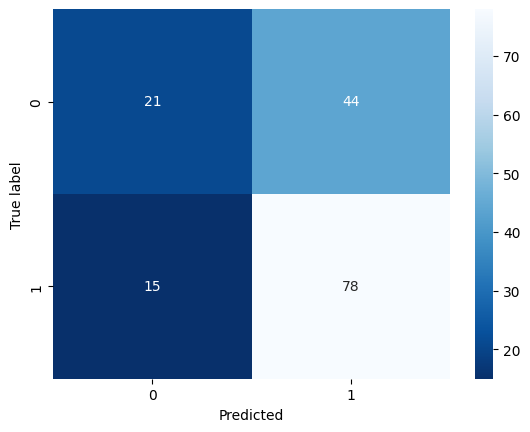

In [210]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

#### Анализ

Для заказчика критичнее ошибка первого рода (ложноположительная, «False Positive»), т.к. если молоко, которое, по мнению заказчика,
должно быть вкусным, таким в действительности не окажется, то он потеряет деньги, т.к. купит корову, которая даст молоко, которое он
не сможет продать.
Поэтому он заинтересован в максимизации метрики Precision, т.к. чем выше значение этой метрики, тем меньше случаев, когда модель выставляет
класс 1 (молоко вкусное) объектам класса 0 (невкусное).

Что касается ошибки второго рода, то ее значение означает упущенную прибыль, т.е. фермер мог бы купить корову, которая дала бы ему вкусное
молоко, которое принесло бы ему прибыль, но этого не случилось. Поэтому метрика Recall для него менее важная. Она будет означать, что он
купил бы не всех коров из стада заказчика, которые могли бы принести ему прибыль (или выбор из таких коров был бы меньше).

##### Порог классификации

Сведем критическую для нашей задачи ошибку — ложноположительная, «False Positive» — к нулю путем регулирования порога классификации.

In [211]:
probabilities_test = model_logr.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]

Теперь попробуем подобрать порог, максимизируя метрику Precision.
Метрика Precision, равная 1, будет означать, что ложноположительных ошибок («False Positive») у нас нет.

In [212]:
precision_best = 0
for threshold in np.arange(0, 1, 0.01):
    predicted_test = (probabilities_one_test >= threshold).astype(int)

    if (predicted_test == 0).all():
        print(f'Все объекты отнесены к классу 0. Дальнейшее повышение порога не имеет смысла. Завершение работы.')
        break
    
    precision_test = precision_score(y_test, predicted_test)
    recall_test = recall_score(y_test, predicted_test)
    
    if precision_test > precision_best:
        precision_best = precision_test
        recall_value = recall_score(y_test, predicted_test)
        precision_best_threshold = threshold

    print("Порог = {:.2f} | Точность = {:.3f} | Полнота = {:.3f}".format(
        threshold, precision_test, recall_test))



print()
print(f'Лучшее значение метрики Precision: {precision_best}')
print(f'Значение метрики Recall: {recall_value}')

print(f'Порог классификации: {precision_best_threshold}')

Порог = 0.00 | Точность = 0.589 | Полнота = 1.000
Порог = 0.01 | Точность = 0.589 | Полнота = 1.000
Порог = 0.02 | Точность = 0.589 | Полнота = 1.000
Порог = 0.03 | Точность = 0.589 | Полнота = 1.000
Порог = 0.04 | Точность = 0.589 | Полнота = 1.000
Порог = 0.05 | Точность = 0.589 | Полнота = 1.000
Порог = 0.06 | Точность = 0.589 | Полнота = 1.000
Порог = 0.07 | Точность = 0.589 | Полнота = 1.000
Порог = 0.08 | Точность = 0.589 | Полнота = 1.000
Порог = 0.09 | Точность = 0.589 | Полнота = 1.000
Порог = 0.10 | Точность = 0.589 | Полнота = 1.000
Порог = 0.11 | Точность = 0.589 | Полнота = 1.000
Порог = 0.12 | Точность = 0.589 | Полнота = 1.000
Порог = 0.13 | Точность = 0.589 | Полнота = 1.000
Порог = 0.14 | Точность = 0.589 | Полнота = 1.000
Порог = 0.15 | Точность = 0.589 | Полнота = 1.000
Порог = 0.16 | Точность = 0.589 | Полнота = 1.000
Порог = 0.17 | Точность = 0.589 | Полнота = 1.000
Порог = 0.18 | Точность = 0.589 | Полнота = 1.000
Порог = 0.19 | Точность = 0.589 | Полнота = 1.000


##### Вывод

Мы видим, что настройка на метрику Precision сильно уменьшает метрику Recall, что означает очень большое количество ложноотрицательных
(«False Negative») ответов, что ведет к большой упущенной выгоде.
Наша модель плохо опознает объекты класса 0 («молоко невкусное», это видно и по матрице ошибок), это ведет к резкому росту ошибок второго рода при настройке порога классификации на метрику Precision, что ведет к большой упущенной выгоде.
Необходим дальнейший анализ признаков (feature engineering) на предмет выработки характерных свойств принадлежности объекта к классу 0.

#### Прогноз вкуса молока коров

In [213]:
data_cow = data_cow_arch

In [214]:
data_cow = data_cow.assign(carb_protein_ratio=data_main['carb_protein_ratio'].mean()*1.05)

Выберем нужные нам признаки

In [215]:
feature_cols = ['pasture_type', 'breed', 'name_dad', 'carb_protein_ratio']

In [216]:
feature_num_cols = ['carb_protein_ratio']

In [217]:
feature_cat_cols = ['pasture_type', 'breed', 'name_dad']

In [218]:
X = data_cow[feature_cols]

In [219]:
X_ohe = encoder_logr.transform(X[feature_cat_cols])

In [220]:
X_ohe = pd.DataFrame(X_ohe, columns=encoder_logr.get_feature_names_out())

<!-- Масштабируем числовые признаки. -->

In [221]:
X_train_scaled = scaler_logr.transform(X[feature_num_cols])

In [222]:
X_scaled = pd.DataFrame(X_train_scaled, columns=feature_num_cols)

Объединяем в окончательные выборки.

In [223]:
X = pd.concat([X_ohe, X_scaled], axis=1)

Получаем прогноз вкуса молока коров

In [224]:
y_is_delicious_pred_one_prec = (model_logr.predict_proba(X)[:, 1] >= precision_best_threshold).astype(int)

In [225]:
data_cow_temp = data_cow_arch

In [226]:
data_cow_temp.assign(is_delicious_pred_one_prec=y_is_delicious_pred_one_prec)

,breed,pasture_type,breed_dad,name_dad,fat_content_curr,protein_curr,is_older2,is_delicious_pred_one_prec
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0
1,Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False,0
2,Соверин,Равнинное,Соверин,Барин,3.59,3.074,True,0
3,Соверин,Холмистое,Айдиал,Буйный,3.40,3.061,True,0
4,Соверин,Равнинное,Айдиал,Буйный,3.64,3.074,True,0
5,Соверин,Равнинное,Соверин,Геркулес,3.63,3.053,False,0
6,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,0
7,Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,True,0
8,Соверин,Равнинное,Соверин,Барин,3.59,3.074,True,0
9,Соверин,Холмистое,Айдиал,Буйный,3.40,3.079,False,0


Мы видим, что если исходить из самых строгих требований по порогу классификации, сводя критическую для фермера ошибку (ошибку первого рода) к нулю, то вкусным, согласно прогнозу, окажется молоко лишь одной коровы.

Ослабим порог классификации с понижением метрики Precision до максимального к единице значения.
Это порог 0.71

In [227]:
y_is_delicious_pred_max_prec = (model_logr.predict_proba(X)[:, 1] >= 0.71).astype(int)

In [228]:
data_cow_temp = data_cow_arch

In [229]:
data_cow_temp.assign(is_delicious_pred_max_prec=y_is_delicious_pred_max_prec)

,breed,pasture_type,breed_dad,name_dad,fat_content_curr,protein_curr,is_older2,is_delicious_pred_max_prec
0,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,1
1,Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,False,0
2,Соверин,Равнинное,Соверин,Барин,3.59,3.074,True,0
3,Соверин,Холмистое,Айдиал,Буйный,3.40,3.061,True,1
4,Соверин,Равнинное,Айдиал,Буйный,3.64,3.074,True,0
5,Соверин,Равнинное,Соверин,Геркулес,3.63,3.053,False,0
6,Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,True,1
7,Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,True,0
8,Соверин,Равнинное,Соверин,Барин,3.59,3.074,True,0
9,Соверин,Холмистое,Айдиал,Буйный,3.40,3.079,False,1


Видим, что таких коров уже больше.
В целом, необходимо выбирать баланс между метриками Recall и Precision, исходя из целей задачи.

### Итог

Добавим прогнозы удоя и вкуса молока в итоговый датасет с коровами, предлагаемыми фермеру на продажу.

In [230]:
data_cow = data_cow.assign(is_delicious_pred_one_prec=y_is_delicious_pred_one_prec, is_delicious_pred_max_prec=y_is_delicious_pred_max_prec, yield_pred=y_yield_pred)
data_cow

NameError: name 'y_yield_pred' is not defined

Если исходить из прогноза модели с самым строгим требованием к метрике Precision, то, как мы видим, остается лишь один-единственный
вариант.

Вот он.

In [231]:
data_cow[data_cow['is_delicious_pred_one_prec'] == 1]

KeyError: 'is_delicious_pred_one_prec'

Но, как мы видим, удой у коровы довольно слабый — всего 6065 кг.

Если мы вспомним о доверительном интервале прогноза и зададимся целью минимизировать риск фермера при покупке коровы по удою,
то необходимо, чтобы нижняя граница интервала прогноза была выше 6000 кг.
В случае с прогнозируемым удоем в 6065 кг такого, конечно же, не может быть, поэтому этот прогноз стоит отвергнуть.

Теперь рассмотрим прогноз модели с чуть ослабленным пороговым значеним.

In [ ]:
data_cows_to_buy = data_cow.query("is_delicious_pred_max_prec == 1 and yield_pred > 6000")

Посмотрим на список коров к покупке

In [ ]:
data_cows_to_buy

Вспомним о доверительном интервале прогноза, в частности, о его нижней границе и предложим фермеру купить коров
с таким предсказанным удоем, чтобы нижнее значение доверительного интервала было выше целевого показателя в 6000
(минимизируя таким образом риск фермера).

In [ ]:
q_0025 = abs(np.quantile(residuals_m3_train, 0.025))

In [ ]:
data_cows_to_buy_low_risk = data_cows_to_buy.query('yield_pred - @q_0025 > 6000')
data_cows_to_buy_low_risk

Интересное обстоятельство: видим, что значение признака «Тип местности» у всех выбранных коров одинаковый.
Если рассмотреть значение этого признака против вкуса коров на примере стада фермера, то увидим такую картину:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(21, 5))
fig.suptitle('Вкус молока в зависимости от типа местности')

data_main[data_main['pasture_type'] == 'Холмистое']['is_delicious'] \
            .apply(lambda x: 'Вкусное' if x >= True else 'Невкусное') \
            .value_counts() \
            .plot(ax=ax[0], kind='pie', ylabel='Вкус молока', title='Вкус молока для холмистого типа местности', autopct='%1.1f%%');

data_main[data_main['pasture_type'] != 'Холмистое']['is_delicious'] \
            .apply(lambda x: 'Вкусное' if x >= True else 'Невкусное') \
            .value_counts() \
            .plot(ax=ax[1], kind='pie', ylabel='Вкус молока', title='Вкус молока для нехолмистого типа местности', autopct='%1.1f%%');


То есть большинство коров фермера, пасшихся на нехолмистой местности, давали невкусное молоко!
Наш прогноз соответствует этому обстоятельству.
Фермеру настоятельно рекомендуется обращать на него внимание!

Окончательно,

In [232]:
data_cows_to_buy_final = data_cows_to_buy_low_risk
data_cows_to_buy_final

NameError: name 'data_cows_to_buy_low_risk' is not defined

#### Выводы о моделях регрессии

В нашей задаче были использованы следующие методы улучшения качества модели:
* Отбор признаков на основе корреляционного анализа, а также репрезентативности всех групп характеристик (коровы, корма, пастбищ, молока)
* Трансформация признаков для придания им большей информативности для линейной регрессии. В частности, один из признаков был преобразован
    в бинарный категориальный, значения другого признака были возведены в квадрат.
* Выбор порога классификации с целью максимизации интересующей нас метрики.

Для улучшения моделей линейной и логистической регрессии необходимы дальнейшие исследования.
В частности, из анализа остатков мы видим, что для коров с удоем выше 6000 мы имеем нелинейно распределенные остатки.
Скорее всего, на этапе сбора данных не учли какие-то признаки.
Кроме того, 
В ходе анализа модели логистической регрессии было выяснено, что у нее большая ошибка первого рода.
Модель плохо опознает объекты класса 0 («молоко невкусное»).
Необходимо дальнейшее исследование признаков (feature engineering) на предмет выявления характерных особенностей принадлежности объекта классу 0.

В целом, в задаче классификации при анализе рисков и экономических расчетов важна матрица ошибок (confusion matrix), а также метрики Recall и Precision.
Мы увидели это на примере нашей задачи, в которой ошибка первого рода (правый верхний квадрат матрицы ошибок) означала потерянные инвестиции,
а ошибка второго рода (левый нижний) — упущенную выгоду.
Необходимо выбирать некоторый компромисс между значениями этих двух метрик.